# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

from colorama import Back, Fore, Style
import ast
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
demographics_data = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file
feature_summary = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

def print_styled(text):
    """
    A simple Function to print styled text with a fixed format of blue text, bold for a neat report
    """
    print(Style.BRIGHT + Fore.BLUE + text + Style.RESET_ALL)

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of rows ...)
print_styled("General Demographics Data (AZDIAS)")
print_styled(f"Rows and Columns: {demographics_data.shape}")
display(demographics_data.head())
display(demographics_data.describe())

General Demographics Data (AZDIAS)
Rows and Columns: (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [5]:
# Check the structure of the feature summary file
print_styled("\nFeature Summary Data:")
print_styled(f"Rows and Columns: {feature_summary.shape}")
print("-" * 80)
print(feature_summary.head(15))
print("-" * 80)
display(feature_summary.describe())


Feature Summary Data:
Rows and Columns: (85, 4)
--------------------------------------------------------------------------------
                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP         

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


In [6]:
# Data Dictionary file seems to be a text/Markdown file so nothing much for now ..
print_styled("\nData Dictionary file seems to be a text/Markdown file so nothing much for now ...")


Data Dictionary file seems to be a text/Markdown file so nothing much for now ...


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Clean the `missing_or_unknown` column
# parse the string representation of lists into Python lists
def parse_missing_codes(row):
    try:
        return ast.literal_eval(row['missing_or_unknown'])
    except (ValueError, SyntaxError):
        return []  # fallback to default value for exceptions

# Parse the `missing_or_unknown` column in the feature summary
feature_summary['missing_or_unknown'] = feature_summary.apply(parse_missing_codes, axis=1)

# Just Looping through each row in the feature summary
for _, row in feature_summary.iterrows():
    column = row['attribute']  # Get the column name
    missing_codes = row['missing_or_unknown']  # Get the missing/unknown codes
    
    # Replace matching values with NaN if the column exists in the dataset
    if column in demographics_data.columns:
        demographics_data[column] = demographics_data[column].replace(missing_codes, np.nan)

# Output ..
print_styled("Cleaned Demographics Dataset:")
display(demographics_data.head())

Cleaned Demographics Dataset:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

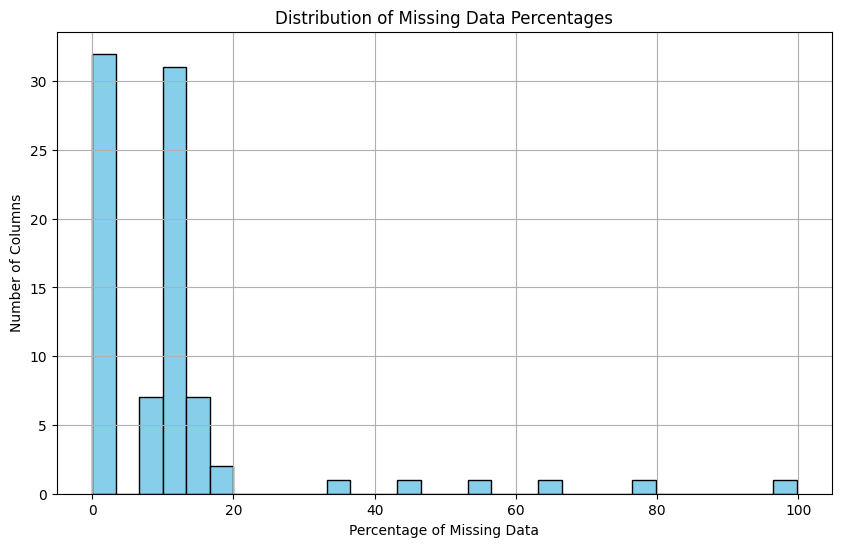

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#I'll check the percentage of missing values per column and Plot 
missing_percentages = demographics_data.isnull().mean() * 100
#Plot the missing value percentages using matplotlib
plt.figure(figsize=(10, 6))
missing_percentages.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Missing Data Percentages")
plt.xlabel("Percentage of Missing Data")
plt.ylabel("Number of Columns")
plt.grid(True)
plt.show()

In [8]:
# Investigate patterns in the amount of missing data in each column.

# #I'll just print the actual values for better insights
# Categorize columns by missing percentage ranges
grouped_by_missing = {
    '0-10%': missing_percentages[missing_percentages <= 10],
    '10-30%': missing_percentages[(missing_percentages > 10) & (missing_percentages <= 30)],
    '30-50%': missing_percentages[(missing_percentages > 30) & (missing_percentages <= 50)],
    '50-70%': missing_percentages[(missing_percentages > 50) & (missing_percentages <= 70)],
    '70-100%': missing_percentages[missing_percentages > 70]
}

# Print the groups
for group, columns in grouped_by_missing.items():
    print_styled(f"\n{group} missing data columns:")
    print(columns)


0-10% missing data columns:
ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GFK_URLAUBERTYP          0.544646
GREEN_AVANTGARDE         0.000000
LP_FAMILIE_FEIN          8.728699
LP_FAMILIE_GROB          8.728699
LP_STATUS_FEIN           0.544646
LP_STATUS_GROB           0.544646
RETOURTYP_BK_S           0.544646
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST               0.000000
SEMIO_ERL                0.000000
SEMIO_KULT               0.000000
SEMIO_RAT                0.000000
SEMIO_KRIT               0.000000
SEMIO_DOM                0.000000
SEMIO_KAEM         

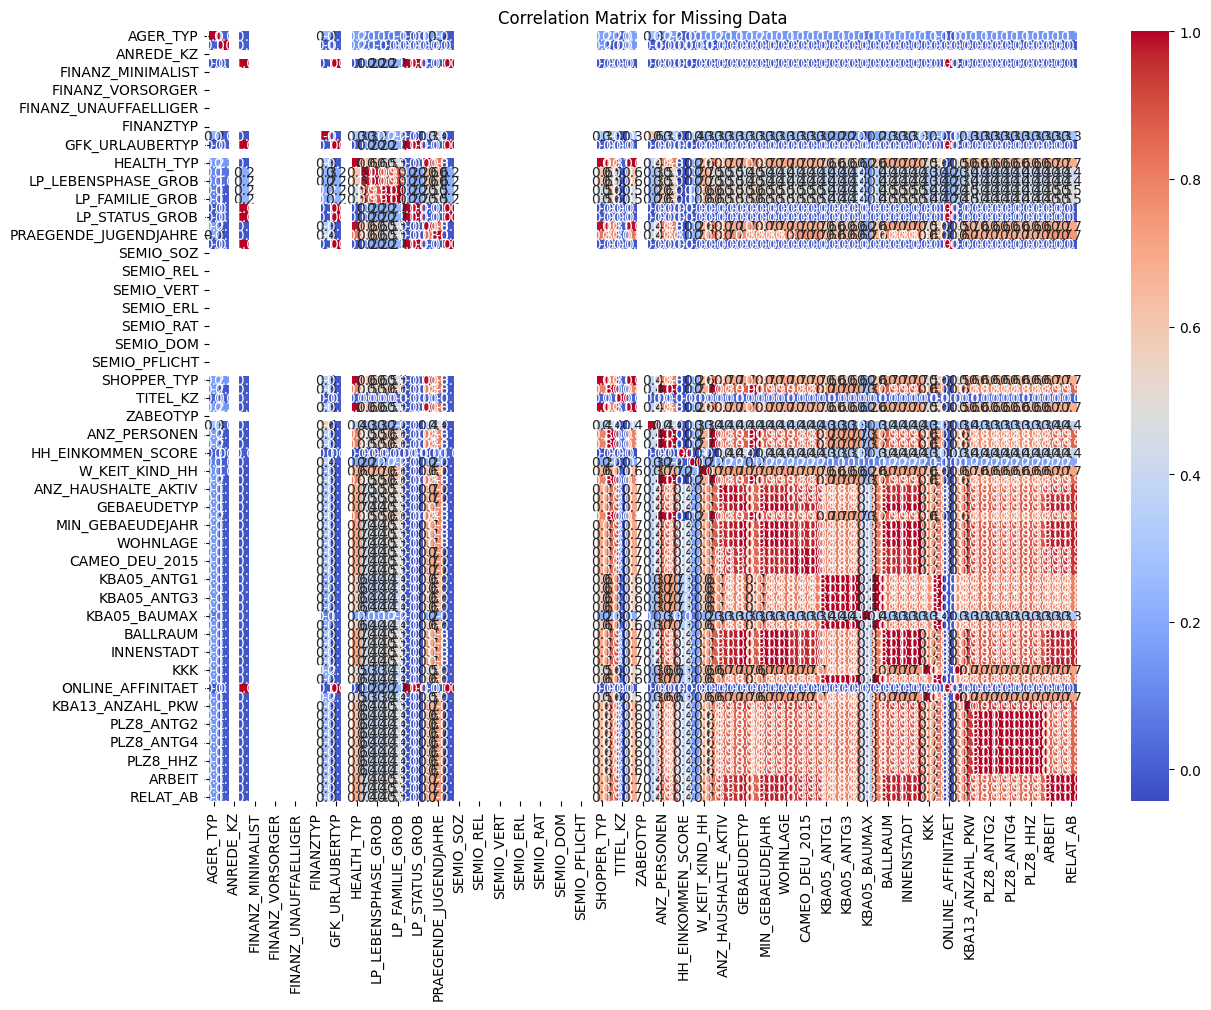

In [12]:
# A quick heatmap by creating a binary matrix indicating whether a value is missing (True) or not (False)
missing_binary_matrix = demographics_data.isnull()

# Calculate pairwise correlation between missing values in columns
missing_correlation = missing_binary_matrix.corr()

#visualize the correlation matrix as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(missing_correlation, annot=True, cmap='coolwarm', fmt='.1f')
plt.title("Correlation Matrix for Missing Data")
plt.show()

AGER_TYP                76.955435
ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
dtype: float64

count    85.000000
mean     11.052662
std      16.449808
min       0.000000
25%       0.000000
50%      10.451729
75%      13.073637
max      99.757636
dtype: float64


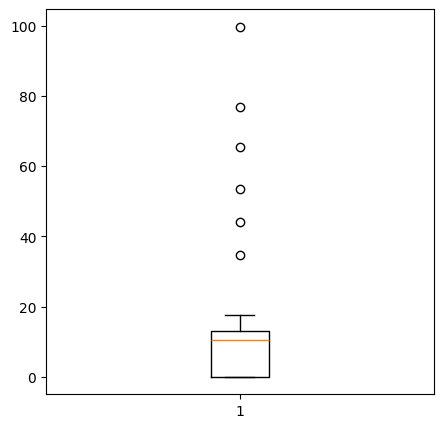

In [9]:
# creating a box plot to indicate the outliers
percent_missing_columns = demographics_data.isnull().sum()/len(demographics_data)*100
display(percent_missing_columns.head())
print(percent_missing_columns.describe())

fig = plt.figure(figsize =(5, 5))
plt.boxplot(percent_missing_columns)
plt.show()

In [10]:
# print before drop coulmns ..
print_styled("Displaying demographics_data before dropping the coulmns ..")
display(demographics_data.head())

Displaying demographics_data before dropping the coulmns ..


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
missing_percentages = demographics_data.isnull().mean()
missing_threshold = 0.5 # Further details are provided in Discussion 1.1.2: Assessing Missing Data in Each Column

# Flag columns with more than the missing_threshold percentage of missing values
columns_to_drop = missing_percentages[missing_percentages > missing_threshold].index.tolist()

# Calculate variance for numeric columns only
numeric_data = demographics_data.select_dtypes(include=[np.number])
low_variance_columns = numeric_data.var()[numeric_data.var() < 1e-5].index.tolist()

# Combine the columns to drop
columns_to_drop += low_variance_columns

# Drop the identified columns from the dataset
demographics_data = demographics_data.drop(columns=columns_to_drop, axis=1)

# Output results
print_styled(f"Removed {len(columns_to_drop)} outlier columns. Remaining columns: {demographics_data.shape[1]}")
print("Dropped columns:")
print(", ".join(columns_to_drop))
print("-" * 80)
display(demographics_data.head())

Removed 4 outlier columns. Remaining columns: 81
Dropped columns:
AGER_TYP, TITEL_KZ, KK_KUNDENTYP, KBA05_BAUMAX
--------------------------------------------------------------------------------


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,NaN,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,13.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

#### Columns with High Missing Data

When analyzing missing data, we focus on columns with a significantly higher or lower percentage of missing values compared to the rest. Below are columns with a high percentage of missing data:

- **`TITEL_KZ`**: 99.76% missing  
  - This extremely high percentage suggests the feature might be an outlier or not useful. It could be omitted.
- **`AGER_TYP`**: 76.96% missing  
  - The high percentage of missing data requires further investigation to determine its relevance.
- **`KK_KUNDENTYP`**: 65.60% missing  
  - Relatively high missingness, potentially indicating an outlier.
- **`KBA05_BAUMAX`**: 53.47% missing  
  - Another feature with a significant amount of missing data, potentially an outlier.

#### Dataset Overview
Again The demographics dataset consists of **891,211 rows** (representing individuals) and **85 columns** (features). Given the large size of the dataset, assessing missing data in this context is crucial. 

- **Threshold for Exclusion:** If features with more than 50% missing data are excluded, the dataset would retain **445,605 rows**.
  - Investigate patterns of missingness for columns below the threshold.
  - Need to assess whether imputation, domain-specific knowledge, or further data collection could address missing values.


#### Reviewing Block Structures in the Heatmap

The blocks of missingness suggest correlations between variables i.e.

- **`HEALTH_TYP`** and **`SHOPPER_TYP`** appear to align in their missingness.
- **Geographical variables** (e.g., `CAMEO_DEU_2015`, `KBA05_ANTG1`) form clusters.

This indicates that some variables may be systematically missing together, possibly because they depend on shared characteristics like region, demographics, or survey participation.



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?

# Calculate the percentage of missing data per row from the dataset without features outliers
row_missing_percentages = demographics_data.isnull().mean(axis=1) * 100

print_styled("Reporting row-level missing percentages for the cleaned demographics dataset (feature outlier columns removed):")
print(row_missing_percentages.describe())
print_styled("\nA sneek peak:")
print(row_missing_percentages.head())

Reporting row-level missing percentages for the cleaned demographics dataset (feature outlier columns removed):
count    891221.000000
mean          7.946886
std          16.787822
min           0.000000
25%           0.000000
50%           1.234568
75%           3.703704
max          61.728395
dtype: float64

A sneek peak:
0    55.555556
1     1.234568
2     0.000000
3     8.641975
4     0.000000
dtype: float64


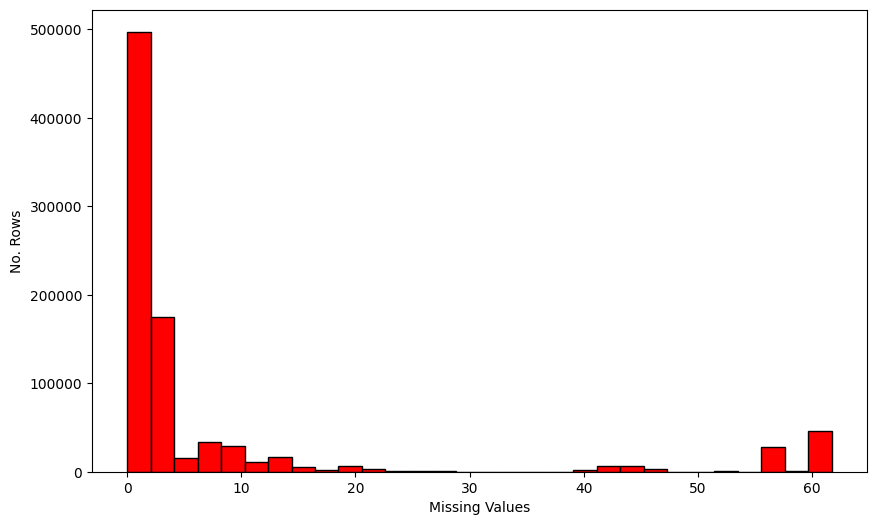

In [11]:
plt.figure(figsize=(10, 6))
row_missing_percentages.plot(kind='hist', bins=30, color='red', edgecolor='black')
plt.ylabel('No. Rows')
plt.xlabel('Missing Values')
plt.show()

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Threshold for missing data
row_missing_threshold = 50

# Spliting the dataset into two subsets as requested
subset_few_missing = demographics_data[row_missing_percentages <= row_missing_threshold]
subset_many_missing = demographics_data[row_missing_percentages > row_missing_threshold]

Rows with <= 50% missing data: 817102
Rows with > 50% missing data: 74119


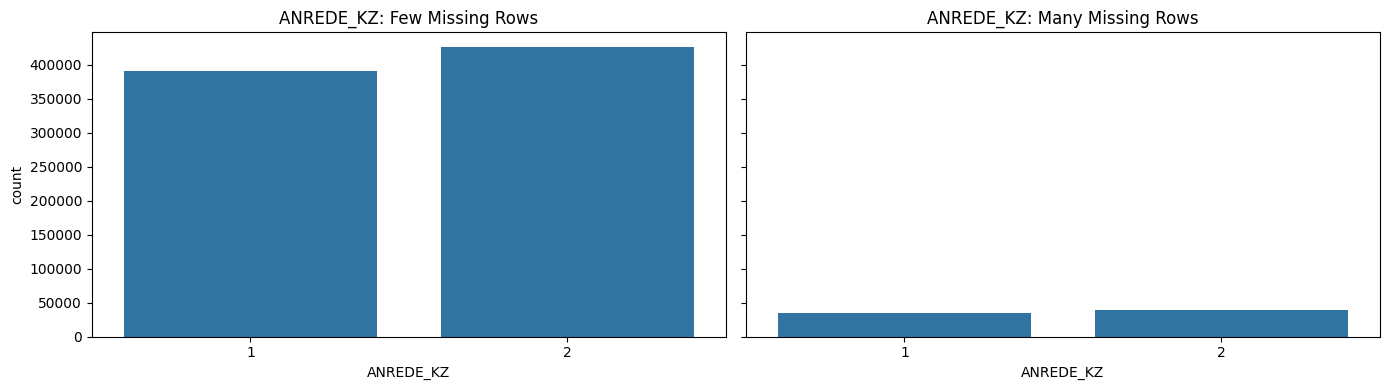

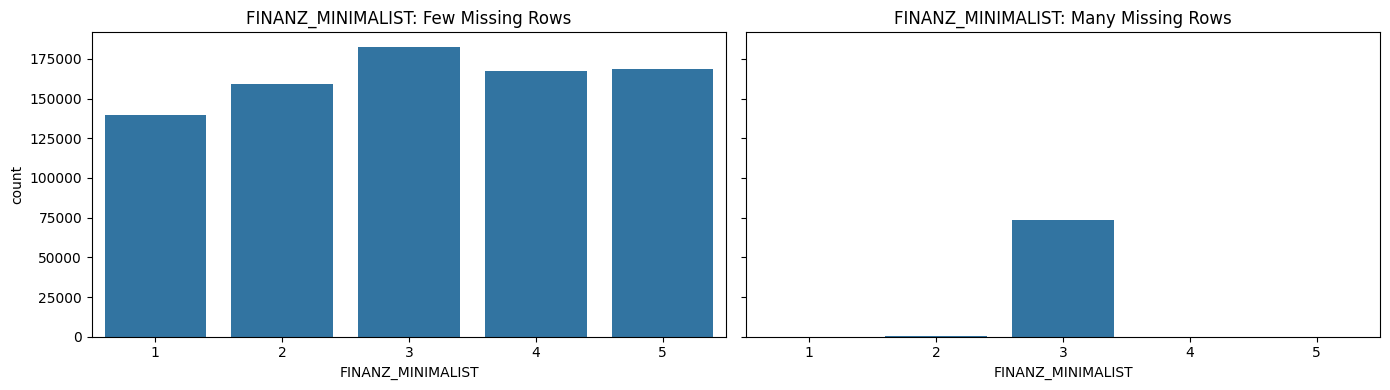

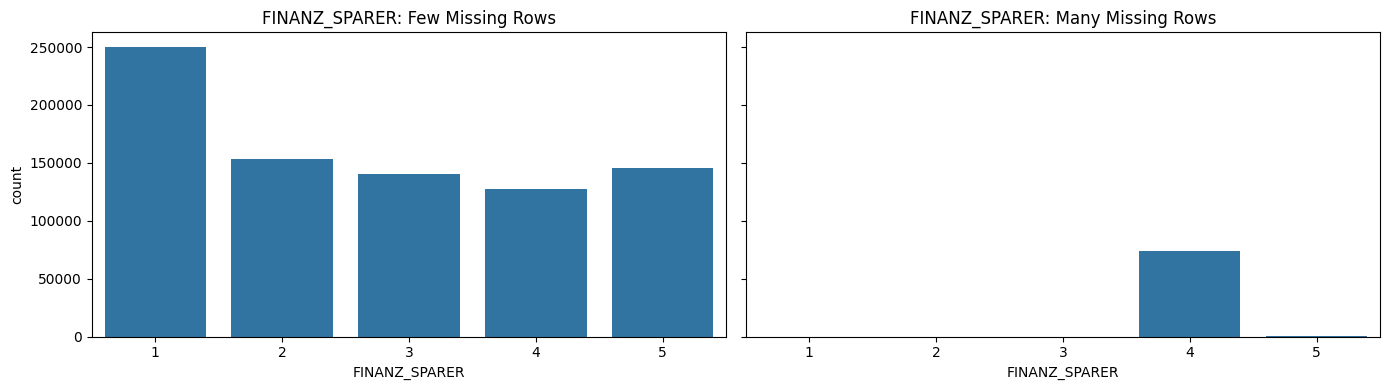

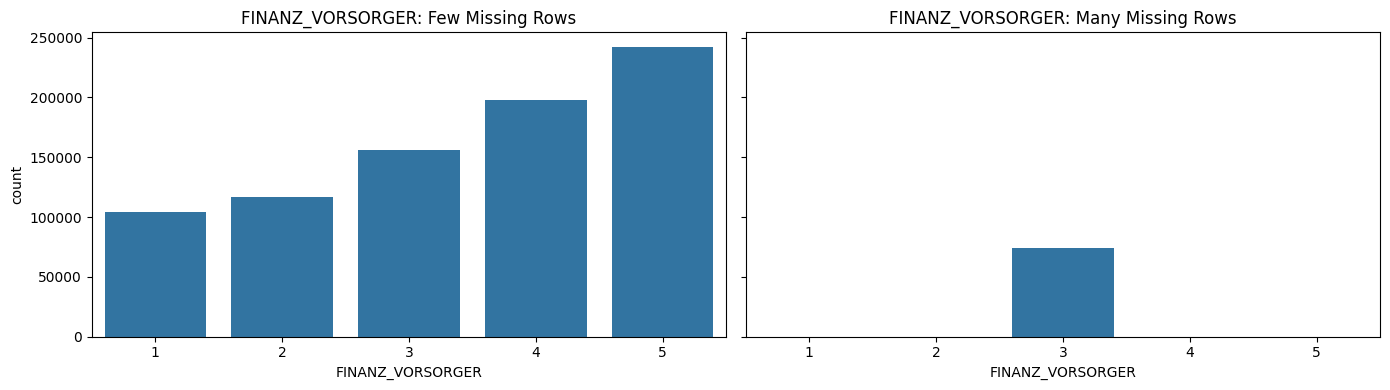

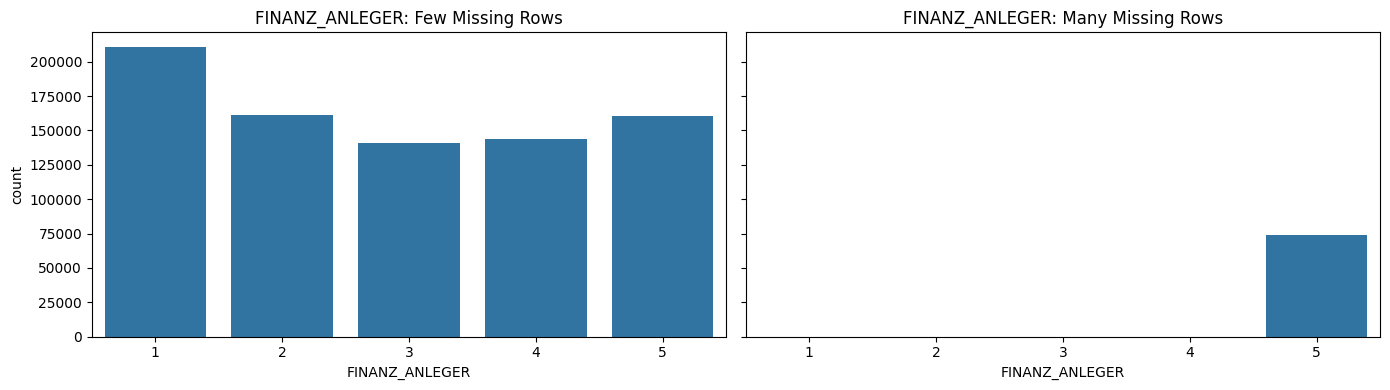

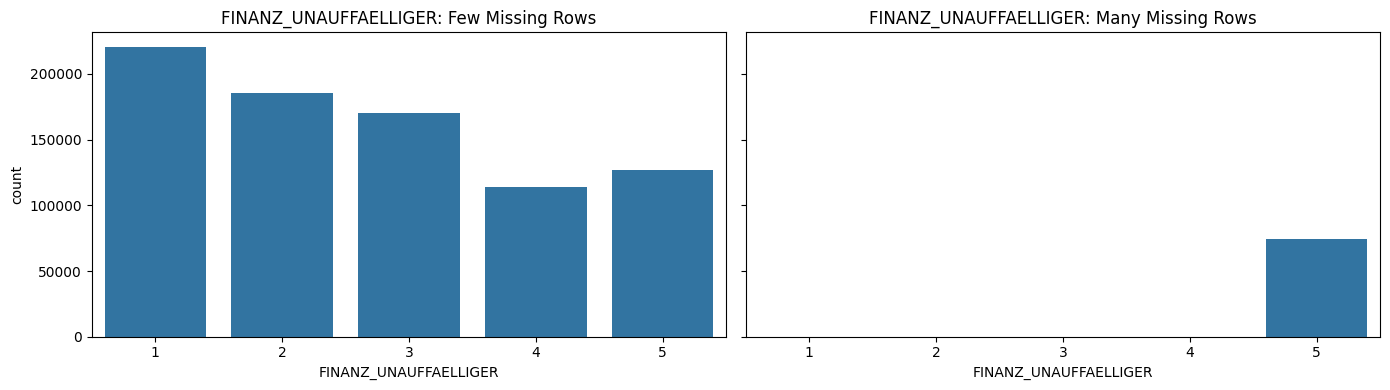

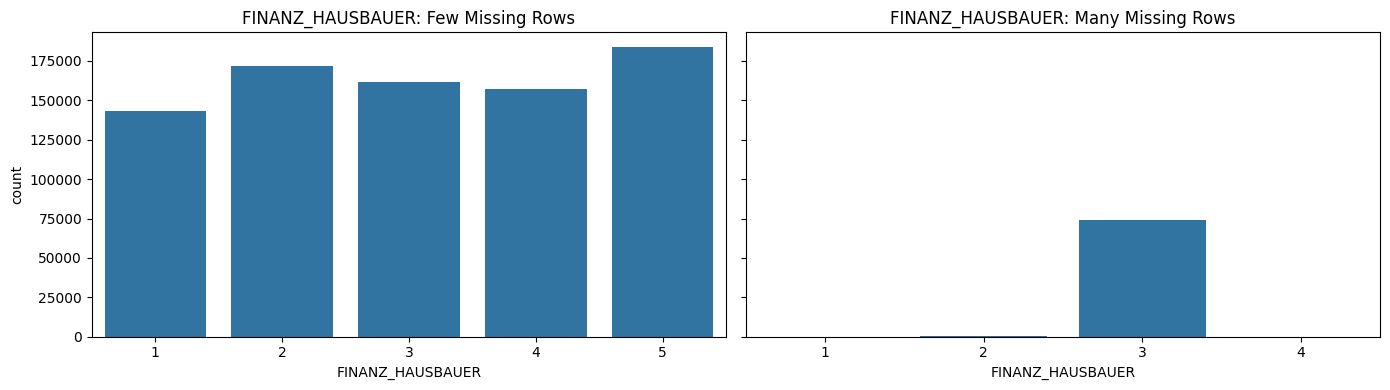

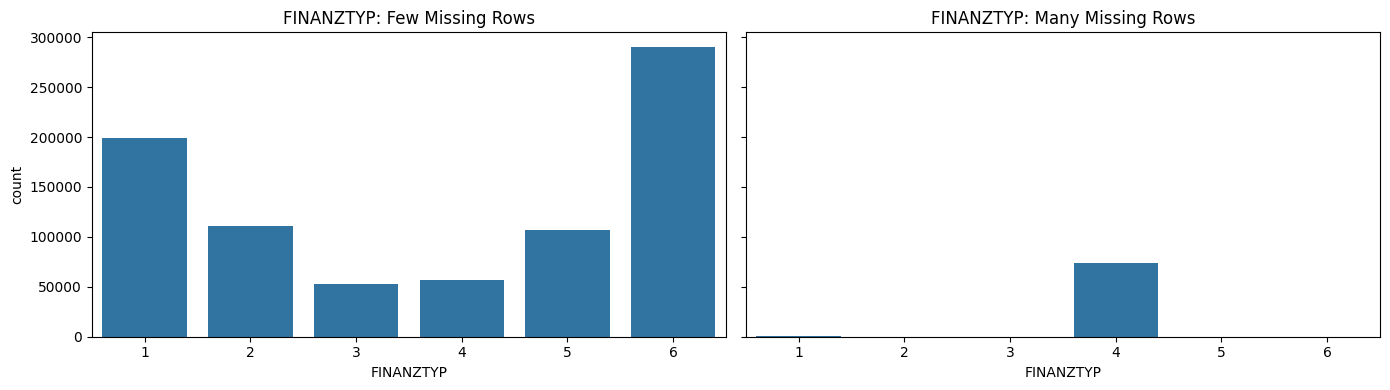

In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# I'll select columns with minimal missing values for comparison mainly the ones with zero missings ..
#I can do it dynamiccly as follows:
# columns_to_compare percent_missing_columns[percent_missing_columns == 0] .. complete_cols[:8]
columns_to_compare = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP']

# Output the size of subsets
print_styled(f"Rows with <= {row_missing_threshold}% missing data: {subset_few_missing.shape[0]}")
print_styled(f"Rows with > {row_missing_threshold}% missing data: {subset_many_missing.shape[0]}")

# A function to compare distributions
def compare_distributions(column):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
    sns.countplot(data=subset_few_missing, x=column, ax=axes[0])
    axes[0].set_title(f'{column}: Few Missing Rows')
    sns.countplot(data=subset_many_missing, x=column, ax=axes[1])
    axes[1].set_title(f'{column}: Many Missing Rows')
    plt.tight_layout()
    plt.show()

# Compare distributions for selected columns
for col in columns_to_compare:
    compare_distributions(col)


#### Discussion 1.1.3: Assess Missing Data in Each Row

Observations on Missing Data Patterns
Distribution Differences:
I observed that in columns like FINANZ_MINIMALIST, FINANZ_SPARER, and FINANZ_VORSORGER, the distributions for the "Few Missing Rows" subset are broader, with all categories represented relatively evenly. Howeever for the "Many Missing Rows" subset, the distributions are more skewed, with specific categories (e.g., category 3 in some columns) dominating the counts.

Subset Sizes:
The "Few Missing Rows" subset constitutes the majority of the dataset, indicating that most data entries are relatively complete and likely reliable for our analysis. The "Many Missing Rows" subset, though smaller, could still introduce potential biases if included in the analysis without proper handling.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [15]:
# How many features are there of each data type?
print_styled("Number of Features for Each Data Type")
features = subset_few_missing.keys().tolist()
features = feature_summary[feature_summary['attribute'].isin(features)]
features['type'].value_counts()

Number of Features for Each Data Type


type
ordinal        49
categorical    18
numeric         7
mixed           6
interval        1
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [16]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Identify categorical variables
categorical_cols = subset_few_missing.select_dtypes(include=['object', 'category']).columns

# Assess unique value counts for each categorical variable
value_counts = subset_few_missing[categorical_cols].nunique()

# Separate binary and multi-level categorical variables
binary_categoricals = value_counts[value_counts == 2]
multi_level_categoricals = value_counts[value_counts > 2]

# Check for non-numeric binary variables
non_numeric_binary = [col for col in binary_categoricals.index if demographics_data[col].dtype == 'object']

# Output the results
print_styled("Binary Categorical Variables (Non-Numeric Encoding Required):")
print(non_numeric_binary)
display(binary_categoricals)

print_styled("\nBinary Categorical Variables (Numeric or Already Encoded):")
print(binary_categoricals.index.difference(non_numeric_binary))
display(non_numeric_binary)

print_styled("\nMulti-Level Categorical Variables:")
print(multi_level_categoricals.index)
display(multi_level_categoricals)

Binary Categorical Variables (Non-Numeric Encoding Required):
['OST_WEST_KZ']


OST_WEST_KZ    2
dtype: int64


Binary Categorical Variables (Numeric or Already Encoded):
Index([], dtype='object')


['OST_WEST_KZ']


Multi-Level Categorical Variables:
Index(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'], dtype='object')


CAMEO_DEUG_2015    10
CAMEO_DEU_2015     45
CAMEO_INTL_2015    22
dtype: int64

In [16]:
# Re-encode categorical variable(s) to be kept in the analysis.
print_styled("Before categorical encoding:")
display(subset_few_missing[binary_categoricals.index].head())

Before categorical encoding:


,OST_WEST_KZ
1,W
2,W
3,W
4,W
5,W


In [17]:
print_styled("After categorical encoding:")
subset_few_missing.loc[:, 'OST_WEST_KZ'] = subset_few_missing['OST_WEST_KZ'].replace({'W': 0, 'O': 1})
display(subset_few_missing[binary_categoricals.index].head())

After categorical encoding:


,OST_WEST_KZ
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0


In [18]:
# Drop the columns from the dataset
temp_subset_few_missing = subset_few_missing.drop(columns=multi_level_categoricals.index)

# Verify the changes
print("Showcase the remaining columns if we exclude/dropping multi-level categorical variables:")
print(temp_subset_few_missing.columns)
print("Note: I'll drop them from subset_few_missing later on a cleanup step before moving to Step#2-Feature Transformation")


Showcase the remaining columns if we exclude/dropping multi-level categorical variables:
Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 

#### Discussion 1.2.1: Re-Encode Categorical Features

- **Kept**: Numeric and interval data
- **Dropped**: Multi-level categorical variables. (left more details below)
- **Adjusted**: Binary categorical features (e.g., `OST_WEST_KZ`) will be re-encoded to 0 and 1 instead of using 'W' and 'O'.

##### Reviewing the Multi-Level Categorical Variables:
The following variables are multi-level categorical:
- `CAMEO_DEUG_2015`: 10 unique levels
- `CAMEO_DEU_2015`: 45 unique levels
- `CAMEO_INTL_2015`: 22 unique levels

**Impact**: Adding 77 new columns might be acceptable for a small to medium dataset, but it could lead to overfitting or computational overhead also I did'nt feel like these are relavant much for our analysis task. Therefore, I decided to drop these columns.

**If I want to keep these variables**, I will apply One-Hot Encoding as follows:
```python
multi_level_cols = multi_level_categoricals.index  # Get the column names
demographics_data = pd.get_dummies(demographics_data, columns=multi_level_cols, prefix=multi_level_cols, drop_first=False)



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [19]:
mixed_features = features[features['type'] == 'mixed']['attribute']
display(mixed_features.head())

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
Name: attribute, dtype: object

In [67]:
display(subset_few_missing['PRAEGENDE_JUGENDJAHRE'].head())

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [20]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Extract decade as an interval variable
subset_few_missing.loc[:, 'GENERATION_DECADE'] = subset_few_missing['PRAEGENDE_JUGENDJAHRE'] // 10
print_styled("GENERATION_DECADE:")
display(subset_few_missing['GENERATION_DECADE'].head())

# Extract movement as a binary variable (mainstream=0, avantgarde=1)
subset_few_missing.loc[:, 'MOVEMENT_TYPE'] = subset_few_missing['PRAEGENDE_JUGENDJAHRE'] % 10
print_styled("MOVEMENT_TYPE:")
display(subset_few_missing['MOVEMENT_TYPE'].head())

GENERATION_DECADE:


1    1.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: GENERATION_DECADE, dtype: float64

MOVEMENT_TYPE:


1    4.0
2    5.0
3    8.0
4    8.0
5    3.0
Name: MOVEMENT_TYPE, dtype: float64

In [21]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Investigate non-numeric values

# Identify and print non-numeric values safely
non_numeric_values = subset_few_missing.loc[
    ~subset_few_missing['CAMEO_INTL_2015'].astype(str).str.isdigit(), 'CAMEO_INTL_2015'
]
print("Non-numeric values:", non_numeric_values.head())

# Replace non-numeric values with NaN safely using .loc
subset_few_missing.loc[:, 'CAMEO_INTL_2015'] = pd.to_numeric(subset_few_missing['CAMEO_INTL_2015'], errors='coerce')

# After replacing non-numeric values with NaN, drop rows with missing values safely
subset_few_missing = subset_few_missing.dropna(subset=['CAMEO_INTL_2015'])

# Convert the cleaned column to integers
subset_few_missing.loc[:, 'CAMEO_INTL_2015'] = subset_few_missing['CAMEO_INTL_2015'].astype(int)

# Extract 'tens' and 'ones' digits safely using .loc
subset_few_missing.loc[:, 'WEALTH'] = subset_few_missing['CAMEO_INTL_2015'] // 10
subset_few_missing.loc[:, 'LIFE_STAGE'] = subset_few_missing['CAMEO_INTL_2015'] % 10

# Verify the results
print(subset_few_missing[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].head())

Non-numeric values: 26    NaN
30    NaN
39    NaN
40    NaN
90    NaN
Name: CAMEO_INTL_2015, dtype: object
  CAMEO_INTL_2015 WEALTH LIFE_STAGE
1              51      5          1
2              24      2          4
3              12      1          2
4              43      4          3
5              54      5          4


#### Discussion 1.2.2: Engineer Mixed-Type Features
I kept `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` for the analysis due to their potential to add meaningful dimensions to the dataset, however I dropped the other mixed-type features as their relevance was minimal.

#### Details:
1. **PRAEGENDE_JUGENDJAHRE**:
   - As mentioned above in this notebook it contains information about:
     - **Decade (generation)**: Extracted as an interval-type variable.
     - **Movement (mainstream vs. avant-garde)**: Extracted as a binary variable.
   - **Engineering Steps**:
     - Created a new column `GENERATION_DECADE` to capture the decade information.
     - Created a new column `MOVEMENT_TYPE` (binary: 0 = mainstream, 1 = avant-garde).

2. **CAMEO_INTL_2015**:
   - Encodes two dimensions:
     - **Wealth (tens place)**: Decomposed into a new variable.
     - **Life Stage (ones place)**: Decomposed into a new variable.
   - **Engineering Steps**:
     - Created a new column `WEALTH` to capture the tens place.
     - Created a new column `LIFE_STAGE` to capture the ones place.
     - Non-numeric or invalid values were identified and replaced with `NaN`, followed by dropping rows with missing values in this feature.

3. **Other Mixed-Type Features**:
   - Other mixed-type features were reviewed but deemed unnecessary for further decomposition or analysis
   - Dropped these features from the dataset.



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [22]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# CleanUp
subset_few_missing = subset_few_missing.drop(columns=multi_level_categoricals.index)

# Drop the column PRAEGENDE_JUGENDJAHRE from the DataFrame as noted above since it was re-engineered ..
subset_few_missing = subset_few_missing.drop(columns=['PRAEGENDE_JUGENDJAHRE'])

print_styled(f"subset_few_missing Rows and Columns: {subset_few_missing.shape}")
display(subset_few_missing.head())
display(subset_few_missing.dtypes)

subset_few_missing Rows and Columns: (791869, 81)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION_DECADE,MOVEMENT_TYPE,WEALTH,LIFE_STAGE
1,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,NaN,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,0.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1.0,4.0,5,1
2,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,0.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1.0,5.0,2,4
3,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,13.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,0.0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.0,8.0,1,2
4,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,0.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.0,8.0,4,3
5,1.0,2,2.0,3,1,5,2,2,5,2,1943.0,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,10.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,0.0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0.0,3.0,5,4


ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR              float64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ         float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
SEMIO_RAT 

In [26]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
print_styled("should be good so far ..")

should be good so far ..


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [23]:
def clean_data(df, feature_summary):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data.

    INPUT:
        df (pd.DataFrame): Original demographics data.
    
    OUTPUT:
        pd.DataFrame: Trimmed and cleaned demographics DataFrame.
    """
    # Step 0: Print the incoming df
    print_styled(f"Raw Dataframe: {df.shape}")
    display(df.head())

    # Step 1: Handle missing or unknown values
    def parse_missing_codes(row):
        try:
            return ast.literal_eval(row['missing_or_unknown'])
        except (ValueError, SyntaxError):
            return []

    feature_summary['missing_or_unknown'] = feature_summary.apply(parse_missing_codes, axis=1)

    for _, row in feature_summary.iterrows():
        column = row['attribute']  # Get column name
        missing_codes = row['missing_or_unknown']  # Get missing/unknown codes
        
        if column in df.columns:
            df[column] = df[column].replace(missing_codes, np.nan)

    print_styled("Data after handling missing or unknown values: ")
    display(df.head())

    # Step 2: Remove outlier columns based on missing percentages and low variance
    missing_threshold = 0.5
    missing_percentages = df.isnull().mean()
    columns_to_drop = missing_percentages[missing_percentages > missing_threshold].index.tolist()

    numeric_data = df.select_dtypes(include=[np.number])
    low_variance_columns = numeric_data.var()[numeric_data.var() < 1e-5].index.tolist()

    columns_to_drop += low_variance_columns
    print_styled(f"Columns to drop: {columns_to_drop}")
    df = df.drop(columns=columns_to_drop, axis=1)

    print_styled("Data after Remove outlier columns based on missing percentages and low variance: ")
    display(df.head())

    # Step 3: Encode categorical variables
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    value_counts = df[categorical_cols].nunique()

    binary_categoricals = value_counts[value_counts == 2]
    multi_level_categoricals = value_counts[value_counts > 2]

    # Identify non-numeric binary columns
    non_numeric_binary = [col for col in binary_categoricals.index if df[col].dtype == 'object']
    if 'OST_WEST_KZ' in df.columns:
        df.loc[:, 'OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W': 0, 'O': 1})
    print_styled("Data after Encode categorical variables: ")
    display(df.head())
    
    # Step 4: Engineer 'PRAEGENDE_JUGENDJAHRE'
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df.loc[:, 'GENERATION_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'] // 10
        df.loc[:, 'MOVEMENT_TYPE'] = df['PRAEGENDE_JUGENDJAHRE'] % 10
        df = df.drop(columns=['PRAEGENDE_JUGENDJAHRE'])

    print_styled("Data after Engineer 'PRAEGENDE_JUGENDJAHRE': ")
    display(df.head())

    # Step 5: Engineer 'CAMEO_INTL_2015'
    if 'CAMEO_INTL_2015' in df.columns:
        df.loc[:, 'CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'], errors='coerce')
        df = df.dropna(subset=['CAMEO_INTL_2015'])
        df.loc[:, 'CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(int)
        df.loc[:, 'WEALTH'] = df['CAMEO_INTL_2015'] // 10
        df.loc[:, 'LIFE_STAGE'] = df['CAMEO_INTL_2015'] % 10

    # Step 6: Drop multi-level categorical variables
    df = df.drop(columns=multi_level_categoricals.index, errors='ignore')

    print_styled(f"Cleaned Dataframe: {df.shape}")
    display(df.head())
    return df
    

In [26]:
# Quick test to validate the clean_data function ;)
print_styled("Quick test to validate the clean_data function .. Note: I made the function to take two param for testing ...")
AZDIAS_data_sample = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
feature_summary_sample = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
cleaned_data = clean_data(AZDIAS_data_sample,feature_summary_sample)

Quick test to validate the clean_data function .. Note: I made the function to take two param for testing ...
Raw Dataframe: (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


Data after handling missing or unknown values: 


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


Columns to drop: ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Data after Remove outlier columns based on missing percentages and low variance: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,NaN,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,13.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


Data after Encode categorical variables: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,NaN,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,0.0,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,0.0,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,13.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,0.0,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,0.0,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


Data after Engineer 'PRAEGENDE_JUGENDJAHRE': 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION_DECADE,MOVEMENT_TYPE
0,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,NaN,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,0.0,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,0.0,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1.0,5.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,13.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,0.0,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.0,8.0
4,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,0.0,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.0,8.0


Cleaned Dataframe: (791869, 81)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION_DECADE,MOVEMENT_TYPE,WEALTH,LIFE_STAGE
1,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,NaN,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,0.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1.0,4.0,5,1
2,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,0.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1.0,5.0,2,4
3,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,13.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,0.0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.0,8.0,1,2
4,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,0.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.0,8.0,4,3
5,1.0,2,2.0,3,1,5,2,2,5,2,1943.0,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,10.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,0.0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0.0,3.0,5,4


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [24]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
total_nan = subset_few_missing.isnull().sum().sum()
print_styled(f"Total NaN values: {total_nan}")

print_styled("Reviewing the df again with NaN per column ..")
nan_per_column = subset_few_missing.isnull().sum()
display(nan_per_column.sort_values(ascending=False))

Total NaN values: 1519807
Reviewing the df again with NaN per column ..


GEBURTSJAHR              307768
ALTER_HH                 227848
KKK                       62910
REGIOTYP                  62910
W_KEIT_KIND_HH            58738
LP_LEBENSPHASE_FEIN       49801
LP_LEBENSPHASE_GROB       46945
KBA05_ANTG1               38093
KBA05_ANTG2               38093
KBA05_ANTG3               38093
KBA05_ANTG4               38093
KBA05_GBZ                 38093
MOBI_REGIO                38093
VERS_TYP                  36464
SHOPPER_TYP               36464
HEALTH_TYP                36464
NATIONALITAET_KZ          33678
LP_FAMILIE_GROB           31200
LP_FAMILIE_FEIN           31200
MOVEMENT_TYPE             28272
GENERATION_DECADE         28272
PLZ8_HHZ                  20971
PLZ8_ANTG4                20971
PLZ8_ANTG3                20971
PLZ8_ANTG2                20971
PLZ8_ANTG1                20971
PLZ8_BAUMAX               20971
PLZ8_GBZ                  20971
KBA13_ANZAHL_PKW          10446
ANZ_HAUSHALTE_AKTIV        6177
GFK_URLAUBERTYP            4721
LP_STATU

In [25]:
# Create an imputer to replace missing values with the mean (can also use 'median' or 'most_frequent')
imputer = SimpleImputer(strategy='mean')
# Apply the imputer to the dataset
subset_few_missing_imputed = pd.DataFrame(imputer.fit_transform(subset_few_missing), columns=subset_few_missing.columns)
print_styled(f"Total NaN values: {subset_few_missing_imputed.isnull().sum().sum()}")
print(f"Missing values after imputation:\n{subset_few_missing_imputed.isnull().sum()}")

Total NaN values: 0
Missing values after imputation:
ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
CJT_GESAMTTYP            0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GEBURTSJAHR              0
GFK_URLAUBERTYP          0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
LP_FAMILIE_FEIN          0
LP_FAMILIE_GROB          0
LP_STATUS_FEIN           0
LP_STATUS_GROB           0
NATIONALITAET_KZ         0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SE

In [32]:
feature_names = subset_few_missing_imputed.keys().tolist()
print_styled("The `feature_names` are required for the `print_component_weights` mapping function.")
display(feature_names)

The `feature_names` are required for the `print_component_weights` mapping function.


['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GEBURTSJAHR',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'ALTER_HH',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'GEBAEUDETYP',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ

In [26]:

# Apply feature scaling to the general population demographics data
scaler = StandardScaler()

# Select numeric columns for scaling
numeric_columns = subset_few_missing_imputed.select_dtypes(include=['number']).columns

# Scale numeric columns in place
subset_few_missing_imputed[numeric_columns] = scaler.fit_transform(subset_few_missing_imputed[numeric_columns])

# Verify the scaled dataset
print_styled("Scaled Data (first 5 rows):\n")
display(subset_few_missing_imputed.head())

Scaled Data (first 5 rows):



,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION_DECADE,MOVEMENT_TYPE,WEALTH,LIFE_STAGE
0,-1.766193,0.957461,0.976270,-1.492493,1.537071,-1.042045,1.466589,0.960128,1.336510,-1.341242,2.077997,0.709370,-0.530848,1.085225,0.395498,2.892077e-01,2.806939e-01,3.724247e-01,-0.792022,-0.965906,-0.363056,-1.684122,0.441985,-0.058947,0.002930,-0.462645,-1.683936,-1.111565,-1.435533,-0.578547,1.274057,-0.311919,1.338012,-0.158521,1.516859,1.289418,1.418913,10.849110,0.986564,1.150702,-1.106632e-15,0.232793,-0.060465,1.024148,-6.784767e-01,0.565451,0.167711,-0.12585,1.954939,-1.303043,-0.383855,-0.515616,-0.026425,-1.089545,-1.041545,-0.632590,2.713985,-1.661927,0.847907,-0.550231,1.703698,-0.798708,-7.694542e-01,-1.406380,0.171697,-8.357686e-01,1.015124,-0.263743,0.217062,0.414369,0.418257,-0.655775,1.443433,0.563598,-0.167320,-0.130201,0.683375,1.038041,-0.144585,1.186692,-1.261498
1,0.201264,0.957461,-0.328709,-1.492493,0.863911,-1.768482,-0.570339,0.245381,1.336510,-1.341242,0.856436,0.709370,1.883778,1.085225,-1.124466,-1.087186e+00,-7.555471e-01,-8.278732e-01,-0.507075,-0.302402,-0.363056,-0.305535,-0.073231,-1.627042,-0.520314,-0.462645,-0.141380,-0.160240,0.753731,-0.578547,0.064364,1.393309,1.338012,1.447110,-0.638633,-0.410083,0.421124,-0.092173,-1.062547,1.150702,5.323587e-01,-0.631017,-0.060465,-0.270306,-6.784767e-01,0.565451,0.103661,-0.12585,-0.678117,1.279451,-0.383855,-0.515616,-1.055071,-0.360119,1.426419,0.377875,-0.491743,-0.119380,-0.984281,0.032283,-0.269032,0.285479,-7.694542e-01,0.028221,-0.473129,-1.403283e+00,0.271823,0.778950,0.217062,-0.613488,-0.975556,-0.655775,0.401299,0.563598,-0.167320,-0.130201,-0.790686,1.038041,0.242231,-0.861798,0.759018
2,1.184993,0.957461,-0.981199,0.685721,-0.482408,1.137267,-0.570339,-1.184113,-0.795465,1.056096,-0.724407,-1.817121,-0.530848,-0.270738,0.000000,-2.444966e-16,1.150459e-16,-2.665197e-16,1.202608,1.024605,-0.363056,-0.994829,0.441985,-1.627042,-1.043558,-1.508049,-0.141380,-0.160240,1.301047,-0.067773,-0.540482,-0.311919,-0.305020,0.376690,-0.099760,0.156417,-0.576665,-0.092173,-1.062547,-0.270224,-7.135978e-01,-1.494828,-0.060465,-2.211987,-5.188475e-16,0.565451,-0.472790,-0.12585,-0.678117,0.633828,1.177049,-0.515616,1.516543,1.828160,-0.218890,-0.632590,-0.491743,0.651893,-0.068187,-1.132745,0.717333,0.285479,-9.450114e-16,0.745522,-1.117955,-1.008107e-15,-0.071695,-0.263743,-0.884949,0.414369,-0.975556,-0.655775,-0.640835,0.563598,-1.171235,-1.001171,-0.053656,-0.999021,1.402676,-1.544628,-0.587992
3,0.201264,-1.044429,0.976270,0.685721,0.190752,0.410830,-1.249315,0.245381,-0.795465,0.576628,-0.293268,-0.694236,-0.530848,1.085225,1.324365,1.390323e+00,1.575995e+00,1.572723e+00,-0.507075,-0.302402,-0.363056,1.073052,0.957201,-0.058947,0.002930,-0.985347,1.401176,-0.160240,-0.340901,0.953776,-1.145328,-0.880328,-1.400374,-1.228941,-0.099760,-0.976584,0.421124,-0.092173,0.986564,0.440239,1.466826e+00,1.960413,-0.060465,0.376921,-1.262647e+00,0.565451,-0.344690,-0.12585,-0.678117,0.633828,-0.383855,-0.515616,-0.540748,-0.360119,2.249073,0.377

### Discussion 2.1: Apply Feature Scaling

After reviewing the subset_few_missing dataset from the demographic I've worked with so far, found out it has a total of 1,519,807 NaN values, I have ensured that the datasett is clean and doesn't include any additional NaNs. Upon further review, the missing data is significant in some columns, so imputation makes the most sense, particularly for numeric columns. Therefore, I’ve used an imputer to replace missing values with the mean. Finally applied scaling to the dataset (excluding non-numeric columns to avoid distort the analysis Result for our PCA)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [27]:
# Apply PCA to the data.
# Initialize PCA
pca = PCA()

# Fit PCA to scaled data (numeric columns only)
pca.fit(subset_few_missing_imputed[numeric_columns])

PCA()

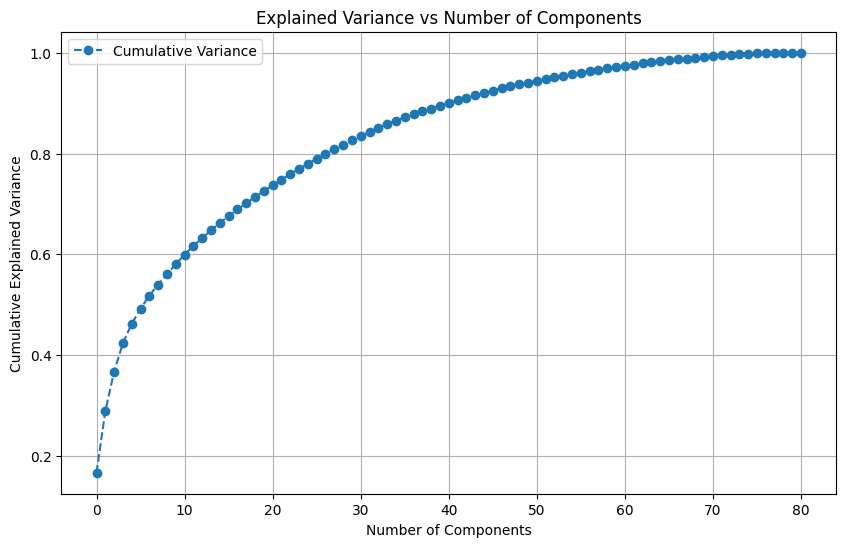

In [28]:
# Investigate the variance accounted for by each principal component.
# Variance explained by each component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', label='Cumulative Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid()
plt.legend()
plt.show()

In [29]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print_styled(f"Number of components to retain 95% variance: {n_components}")

pca = PCA(n_components=n_components)
subset_pca_transformed = pca.fit_transform(subset_few_missing_imputed[numeric_columns])

# Convert to DataFrame for analysis
subset_pca_transformed_df = pd.DataFrame(subset_pca_transformed, 
                                         columns=[f'PC{i+1}' for i in range(n_components)])

# Verify transformed data
print_styled("Transformed PCA Data (first 5 rows):")
display(subset_pca_transformed_df.head())

Number of components to retain 95% variance: 53
Transformed PCA Data (first 5 rows):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
0,3.944545,-3.547458,-2.998916,0.327605,0.820834,3.001785,2.177894,0.664513,-0.109888,-1.545404,0.200672,0.460547,0.395557,-0.143188,-0.890461,-1.675039,-2.228760,10.161008,4.036403,-0.416384,0.954043,0.415006,1.366831,-0.081328,-0.582728,1.310448,-0.550906,-0.026771,-1.445488,-0.515355,0.248979,-0.834532,0.680584,-0.643012,-1.217940,0.732333,0.513147,-0.504894,-0.323287,0.160389,0.004971,-0.244892,-1.080329,-0.041010,-0.437502,-0.038051,-1.211203,0.491341,-0.201994,0.530581,0.290147,0.953476,0.462038
1,0.298417,0.001251,-3.454610,-1.666182,-2.323153,0.707396,-0.307255,-0.106727,-1.887870,-0.263248,1.505240,1.227006,-1.385312,0.896199,-0.426939,0.146835,0.416832,-0.598245,1.261690,0.094048,0.822158,-0.615856,-1.316377,-0.938313,-0.076052,-0.448688,0.116272,0.156153,-0.853076,-0.525481,0.316126,-0.004570,-1.342434,-1.180679,1.021786,0.026125,-0.405805,1.685082,0.485370,0.289699,-0.457961,0.083038,-0.309180,-0.110815,-0.158167,-0.061914,0.272880,-0.648789,-0.555883,0.139721,0.092087,-0.391864,0.058641
2,-4.548727,2.176587,-0.498732,-1.409079,0.067940,-0.960494,0.427602,0.125608,0.242844,0.125999,-0.852000,-1.022661,0.634038,-1.218221,0.689735,-0.579790,0.089754,-0.524481,0.824510,0.420509,-0.782558,-0.078192,0.150040,0.108096,1.345305,0.046566,-0.684980,-0.052781,-0.146201,-1.520927,0.282410,-0.619003,-0.522574,0.337256,-0.707140,0.174496,-1.544921,-0.049898,-0.363838,0.787791,0.791643,-0.227442,-0.430290,-0.306050,-0.938434,1.845306,-0.372915,-0.633849,-0.042661,0.375840,0.434748,0.051337,-0.156403
3,-0.364914,-0.046810,2.922456,4.431938,1.206097,-0.040769,-3.271810,1.054574,-1.126285,-1.368714,0.696175,-0.261794,-1.270959,0.926967,0.719752,0.784805,-0.222178,-0.372038,0.757613,-0.145562,-1.320693,-0.298970,-0.383876,-0.259437,-0.459652,0.206780,1.152331,0.866478,0.129303,-1.323352,-0.632682,-1.039991,0.122358,-0.174849,0.513760,-0.017714,0.129021,-0.155073,-0.312189,0.765684,-0.149751,-0.337123,0.944201,0.328728,0.607591,-0.363479,0.100838,-0.190648,-0.341175,-0.103584,0.329031,-0.620785,-0.033352
4,-0.544987,-0.547797,-0.422969,-4.016666,0.375201,2.188476,-1.231673,-0.923212,4.425692,-1.541609,-0.091272,-0.475814,1.661330,-0.973884,0.360387,-2.360958,0.799328,0.194585,-1.000652,-0.312127,-1.644418,-0.701266,1.285984,0.079213,0.484503,0.576631,0.079059,0.535613,-0.297604,-1.156560,0.015525,-0.924639,-0.544164,-0.045235,0.783055,-0.272847,0.458756,-0.204903,1.387489,0.421099,0.105863,0.763792,-0.601676,-0.422122,0.716525,-0.660955,-0.323668,-0.330795,-0.242159,-0.116304,0.437545,-0.297691,0.115264


### Discussion 2.2: Perform Dimensionality Reduction

I wanted something to preserving significant variability in the data and reduce dimensionality so I opted to retain the first **n_components components**, which together capture approximately **`95%`** of the variance in the dataset. 

###### I followed this notebook suggestions of doing the:
+ **Imputation of Missing Values:** Missing values were replaced using the mean strategy to eliminate NaN values.  
+ **Scaling Features:** Numeric columns were standardized with `StandardScaler` to prepare data for PCA.  
+ **PCA Application:** PCA was used to calculate explained variance for each component and the cumulative variance.  


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [33]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Create the mapping of feature names to their corresponding PCA component weights
def print_component_weights(pca, component_index, feature_names):
    component_weights = pca.components_[component_index]
    
    # Create a DataFrame with feature names and corresponding weights
    feature_weight_df = pd.DataFrame({
        'Feature': feature_names,
        'Weight': component_weights
    })
    
    # Sort by the absolute value of weights (in descending order)
    feature_weight_df['AbsWeight'] = feature_weight_df['Weight'].abs()
    feature_weight_df = feature_weight_df.sort_values('AbsWeight', ascending=False).reset_index(drop=True)
    
    # Print the sorted feature weights for the selected component
    print_styled(f"Principal Component {component_index + 1} Feature Weights:")
    print(feature_weight_df[['Feature', 'Weight']])
    print("\n")

In [34]:
# First principal component
# Call the function for the first component (PC1)
print_component_weights(pca, 0, feature_names)

Principal Component 1 Feature Weights:
                  Feature    Weight
0              MOBI_REGIO -0.217420
1          LP_STATUS_FEIN -0.216806
2          LP_STATUS_GROB -0.214572
3             KBA05_ANTG1 -0.202934
4       FINANZ_MINIMALIST -0.200229
5              PLZ8_ANTG3  0.199111
6              PLZ8_ANTG1 -0.198531
7               KBA05_GBZ -0.194242
8              PLZ8_ANTG4  0.193339
9      HH_EINKOMMEN_SCORE  0.189717
10            PLZ8_BAUMAX  0.188560
11                 WEALTH  0.184008
12            ORTSGR_KLS9  0.172892
13               EWDICHTE  0.171069
14       FINANZ_HAUSBAUER  0.157863
15    LP_LEBENSPHASE_FEIN -0.151584
16            KONSUMNAEHE -0.148726
17               PLZ8_GBZ -0.146138
18             INNENSTADT -0.142659
19    LP_LEBENSPHASE_GROB -0.137909
20             PLZ8_ANTG2  0.135900
21            KBA05_ANTG4  0.135688
22               ZABEOTYP  0.131205
23                 ARBEIT  0.123572
24            KBA05_ANTG3  0.122342
25    ANZ_HAUSHALTE_AKTIV

In [44]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Call the function for the second component (PC2)
print_component_weights(pca, 1, feature_names)

Principal Component 2 Feature Weights:
                  Feature    Weight
0    ALTERSKATEGORIE_GROB  0.248038
1       GENERATION_DECADE -0.240773
2           FINANZ_SPARER -0.238078
3               SEMIO_REL -0.232970
4        FINANZ_VORSORGER  0.230409
5   FINANZ_UNAUFFAELLIGER -0.225516
6             SEMIO_TRADV -0.219097
7           SEMIO_PFLICHT -0.218822
8          FINANZ_ANLEGER -0.207474
9             GEBURTSJAHR -0.205010
10              SEMIO_ERL  0.200167
11               ALTER_HH -0.198453
12             SEMIO_KULT -0.185877
13              SEMIO_RAT -0.174292
14             SEMIO_LUST  0.172360
15      ONLINE_AFFINITAET -0.167120
16         RETOURTYP_BK_S  0.163115
17              SEMIO_FAM -0.153969
18              SEMIO_MAT -0.146544
19         W_KEIT_KIND_HH  0.132690
20          CJT_GESAMTTYP -0.123082
21              FINANZTYP  0.113547
22       FINANZ_HAUSBAUER  0.092711
23      FINANZ_MINIMALIST  0.090176
24             SEMIO_KRIT  0.089051
25        LP_FAMILIE_GROB

In [45]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Call the function for the third component (PC3)
print_component_weights(pca, 2, feature_names)

Principal Component 3 Feature Weights:
                  Feature    Weight
0               ANREDE_KZ -0.367435
1              SEMIO_KAEM -0.339422
2              SEMIO_VERT  0.338370
3               SEMIO_DOM -0.311598
4              SEMIO_KRIT -0.277620
5               SEMIO_FAM  0.267578
6               SEMIO_SOZ  0.265428
7              SEMIO_KULT  0.258615
8               SEMIO_ERL -0.203942
9               SEMIO_RAT -0.183418
10         FINANZ_ANLEGER -0.155638
11      FINANZ_MINIMALIST  0.140480
12            SHOPPER_TYP -0.140360
13              FINANZTYP  0.105501
14              SEMIO_REL  0.104978
15         RETOURTYP_BK_S  0.087367
16         W_KEIT_KIND_HH  0.085122
17              SEMIO_MAT  0.077826
18  FINANZ_UNAUFFAELLIGER -0.074838
19          FINANZ_SPARER -0.073386
20      GENERATION_DECADE -0.068113
21       FINANZ_VORSORGER  0.067321
22            GEBURTSJAHR -0.062777
23               ALTER_HH -0.062664
24               ZABEOTYP -0.055824
25       FINANZ_HAUSBAUER

### Discussion 2.3: Interpret Principal Components

After reviewing the first three PC results I'll write a quick comparision for the Negative/Positive contributions for each of them with their relevant translation from Germany to English:

##### General Notes As we studied for the (PCA):

- **Strong Negative Weights**:  
  Features with strong negative weights suggest they **reduce the value** of the respective principal component when their values increase.

- **Strong Positive Weights**:  
  Features with strong positive weights indicate they **increase the value** of the respective principal component when their values rise.
---

#####  First Component Principal (PC1) Observations:
- **Negative Contributions**:  
  Features like `MOBI_REGIO` (Mobile regional typology), `LP_STATUS_FEIN` (Detailed socio-economic status), and `KBA05_ANTG1` (Number of small cars in the region) 

- **Positive Contributions**:  
  Features like `PLZ8_ANTG3` (Number of 6-10 family houses in the PLZ8 region), `HH_EINKOMMEN_SCORE` (Household income score), and `WEALTH` (Wealth index) 
---

#####  Second Component Principal (PC2) Observations:
- **Negative Contributions**:  
  Features like `GENERATION_DECADE` (Generation by decade), `FINANZ_SPARER` (Financial saver), and `SEMIO_REL` (Religious personality typology) have strong negative weights. Potentially indicating a contrasting dimension, such as younger generations with differing financial behaviors and cultural values.

- **Positive Contributions**:  
  Features like `ALTERSKATEGORIE_GROB` (Broad age category), `FINANZ_VORSORGER` (Financial precautionary saver), and `SEMIO_ERL` (Explorative personality typology) have strong positive weights. This may represent a factor related to age and financial responsibility.
---
##### Third Component Principal (PC3) Observations:

- **Negative Contributions**:  
  Features with strong negative weights include:  
  - `ANREDE_KZ` (Gender)  
  - `SEMIO_KAEM` (Combative personality typology)  
  - `SEMIO_DOM` (Dominant personality typology)  
  - `SEMIO_KRIT` (Critical personality typology)  
  - `SEMIO_ERL` (Explorative personality typology)  

  These eflecting aspects like individual traits or demographics ...

- **Positive Contributions**:  
  Features with strong positive weights include:  
  - `SEMIO_VERT` (Dreamful personality typology)  
  - `SEMIO_FAM` (Family-oriented personality typology)  
  - `SEMIO_SOZ` (Socially-minded personality typology)  
  - `SEMIO_KULT` (Cultural personality typology)  
  - `FINANZ_MINIMALIST` (Minimalist financial type)  

   Representing a focus on social or cultural preferences and minimalism.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [35]:
# Over a number of different cluster counts...
print_styled("In an optimal environment, I would use `range(1, 31)` for a more comprehensive analysis, but for now, I'm focusing on server availability for my Udacity workspace and will use the first 10 odd numbers: `[i for i in range(1, 20, 2)]` ([1, 3, 5, 7, 9, 11, 13, 15, 17, 19]).")

# Store results for the elbow method
cluster_counts = [i for i in range(1, 20, 2)] #range(1, 31) 
print(f"Clusters to run on: {cluster_counts}")
avg_within_cluster_distances = []

# run k-means clustering on the data and...
for k in cluster_counts:
    print(f"running on cluster: {k} ...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # n_init ensures stability in clustering
    kmeans.fit(subset_pca_transformed)
    avg_within_cluster_distances.append(-kmeans.score(subset_pca_transformed) / len(subset_pca_transformed))  # Compute average distance 
    
print("Apply Clustering to General Population has completed.")

In an optimal environment, I would use `range(1, 31)` for a more comprehensive analysis, but for now, I'm focusing on server availability for my Udacity workspace and will use the first 10 odd numbers: `[i for i in range(1, 20, 2)]` ([1, 3, 5, 7, 9, 11, 13, 15, 17, 19]).
Clusters to run on: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
running on cluster: 1 ...
running on cluster: 3 ...
running on cluster: 5 ...
running on cluster: 7 ...
running on cluster: 9 ...
running on cluster: 11 ...
running on cluster: 13 ...
running on cluster: 15 ...
running on cluster: 17 ...
running on cluster: 19 ...
Apply Clustering to General Population has completed.


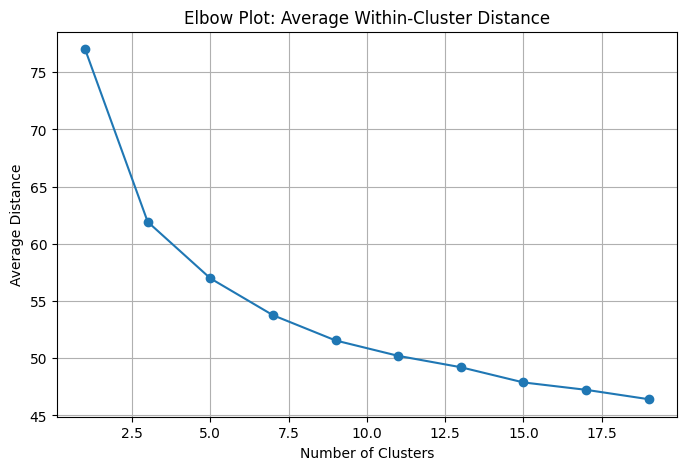

In [36]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(8, 5))
plt.plot(cluster_counts, avg_within_cluster_distances, marker='o')
plt.title('Elbow Plot: Average Within-Cluster Distance')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.grid(True)
plt.show()

In [38]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

optimal_k = 9  # This is the chosen cluster count from the elbow method
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_kmeans.fit(subset_pca_transformed)
print_styled(f"Re-fit the k-means has completed with optimal_k of {optimal_k}.")
# Obtain cluster assignments
cluster_assignments = final_kmeans.labels_

Re-fit the k-means has completed with optimal_k of 9.


### Discussion 3.1: Apply Clustering to General Population

After reviewing the elbow plot, I opted to divide dataset into 5 clusters. This decision relied on the elbow method, which identifies the point where the decline in the average within-cluster distance starts to plateau significantly, As I noted above  the optimal cluster count. Ideally, a broader range of cluster counts (e.g., from 1 to 30) would have been preferable for a more thorough analysis. However, due to server limitations, I restricted the evaluation to the first 10 odd numbers [1, 3, 5, 7, 9, 11, 13, 15, 17, 19].

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [39]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

# Quick check of the customer data
print_styled("Customer Data (CUSTOMERS):")
print_styled(f"Rows and Columns: {customers.shape}")
display(customers.head())
display(customers.describe())

Customer Data (CUSTOMERS):
Rows and Columns: (191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,188439.000000,188439.000000,188439.000000,188439.000000,188439.000000,188439.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,145056.000000,145056.000000,191652.000000,191652.000000,145056.000000,145056.000000,145056.000000,188684.000000,79715.000000,137910.000000,145056.000000,141725.000000,139542.000000,141725.000000,145001.000000,141725.000000,141725.000000,135672.000000,135672.000000,135672.000000,135672.000000,135672.000000,135672.000000,141693.000000,141693.000000,141693.000000,141725.000000,137392.000000,135672.000000,188439.000000,137392.000000,140371.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,4.137958,1003.392733,6.302268,0.367171,1.198396,18.181571,5.422694,4.254448,2.355043,6.687910,3.209251,0.773433,4.248273,3.716311,3.742137,4.414026,4.112788,3.883163,4.185279,5.366477,4.408021,3.682497,3.165879,4.674535,4.483835,4.187246,3.528254,2.919161,0.987754,0.009865,0.021681,0.849008,2.576806,11.352009,2.267828,0.020392,2.942481,3.421803,4.152716,8.646371,4.965863,0.067413,2.369942,3.129978,1993.056659,3.723133,2.207058,1.209004,0.309968,0.153385,1.043826,3.630403,4.301758,3.881702,4.784577,3.852524,2.321569,3.627425,2.764327,3.814341,667.231216,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,1.503946,974.531081,2.877181,0.482035,1.450937,15.009985,4.717907,4.492807,2.052142,3.090573,1.436958,0.495983,3.807671,1.113933,1.718039,1.733128,2.070958,1.840131,2.367407,1.443103,1.720909,1.573090,1.316221,2.041059,1.631941,1.872047,1.493916,1.219224,1.538679,0.098833,0.210424,1.166162,1.168486,6.275026,1.390620,0.152234,1.533347,1.623890,1.974375,1.154001,14.309694,0.545576,2.434227,1.439740,3.080241,2.095540,1.383509,1.086202,0.765292,0.476992,1.384973,1.168496,2.114614,1.607621,1.961473,0.830285,1.100512,1.282444,1.266050,2.075155,340.481722,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00

In [43]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
feature_summary = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
customer_data_cleaned = clean_data(customers, feature_summary)

Raw Dataframe: (191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,4.0,1,5.0,5,1,5,1,2,2,2,NaN,4.0,1,1.0,20.0,5.0,2.0,2.0,10.0,5.0,1.0,4.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3.0,0.0,NaN,1.0,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,NaN,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,NaN,4.0,1,NaN,5,1,5,1,3,2,2,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,NaN,1.0,3,11.0,3.0,0.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,2,2.0,5,1,5,1,4,4,2,NaN,3.0,1,2.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,4.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,0.0,NaN,2.0,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,NaN,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1.0,4.0,1,2.0,5,1,5,2,1,2,6,NaN,10.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,0.0,NaN,1.0,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,NaN,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,NaN,3.0,1,6.0,3,1,4,4,5,2,2,1960.0,2.0,0,3.0,31.0,10.0,10.0,5.0,1.0,1.0,1.0,8.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1.0,0.0,NaN,2.0,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,NaN,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


Data after handling missing or unknown values: 


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,4.0,1,5.0,5,1,5,1,2,2,2,NaN,4.0,1,1.0,20.0,5.0,2.0,2.0,10.0,5.0,1.0,4.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3.0,0.0,NaN,1.0,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,NaN,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,NaN,4.0,1,NaN,5,1,5,1,3,2,2,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,NaN,1.0,3,11.0,3.0,0.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,2,2.0,5,1,5,1,4,4,2,NaN,3.0,1,2.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,4.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,0.0,NaN,2.0,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,NaN,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1.0,4.0,1,2.0,5,1,5,2,1,2,6,NaN,10.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,0.0,NaN,1.0,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,NaN,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,NaN,3.0,1,6.0,3,1,4,4,5,2,2,1960.0,2.0,0,3.0,31.0,10.0,10.0,5.0,1.0,1.0,1.0,8.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1.0,0.0,NaN,2.0,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,NaN,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


Columns to drop: ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Data after Remove outlier columns based on missing percentages and low variance: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,4.0,1,5.0,5,1,5,1,2,2,2,NaN,4.0,1,1.0,20.0,5.0,2.0,2.0,10.0,5.0,1.0,4.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3.0,0.0,1.0,3,10.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,4.0,1,NaN,5,1,5,1,3,2,2,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,1.0,3,11.0,3.0,0.0,NaN,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,2,2.0,5,1,5,1,4,4,2,NaN,3.0,1,2.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,4.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,0.0,2.0,3,6.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,4.0,1,2.0,5,1,5,2,1,2,6,NaN,10.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,0.0,1.0,1,8.0,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,3.0,1,6.0,3,1,4,4,5,2,2,1960.0,2.0,0,3.0,31.0,10.0,10.0,5.0,1.0,1.0,1.0,8.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1.0,0.0,2.0,1,20.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


Data after Encode categorical variables: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,4.0,1,5.0,5,1,5,1,2,2,2,NaN,4.0,1,1.0,20.0,5.0,2.0,2.0,10.0,5.0,1.0,4.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3.0,0.0,1.0,3,10.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,0.0,7.0,1,1A,13,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,4.0,1,NaN,5,1,5,1,3,2,2,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,1.0,3,11.0,3.0,0.0,NaN,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,2,2.0,5,1,5,1,4,4,2,NaN,3.0,1,2.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,4.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,0.0,2.0,3,6.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,0.0,2.0,5,5D,34,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,4.0,1,2.0,5,1,5,2,1,2,6,NaN,10.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,0.0,1.0,1,8.0,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,2.0,1992.0,0.0,7.0,4,4C,24,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,3.0,1,6.0,3,1,4,4,5,2,2,1960.0,2.0,0,3.0,31.0,10.0,10.0,5.0,1.0,1.0,1.0,8.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1.0,0.0,2.0,1,20.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,0.0,3.0,7,7B,41,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


Data after Engineer 'PRAEGENDE_JUGENDJAHRE': 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION_DECADE,MOVEMENT_TYPE
0,4.0,1,5.0,5,1,5,1,2,2,2,NaN,4.0,1,1.0,20.0,5.0,2.0,2.0,10.0,5.0,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3.0,0.0,1.0,3,10.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,0.0,7.0,1,1A,13,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,0.0,4.0
1,4.0,1,NaN,5,1,5,1,3,2,2,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,1.0,3,11.0,3.0,0.0,NaN,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,2,2.0,5,1,5,1,4,4,2,NaN,3.0,1,2.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,0.0,2.0,3,6.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,0.0,2.0,5,5D,34,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,0.0,4.0
3,4.0,1,2.0,5,1,5,2,1,2,6,NaN,10.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,0.0,1.0,1,8.0,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,2.0,1992.0,0.0,7.0,4,4C,24,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,0.0,1.0
4,3.0,1,6.0,3,1,4,4,5,2,2,1960.0,2.0,0,3.0,31.0,10.0,10.0,5.0,1.0,1.0,1.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1.0,0.0,2.0,1,20.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,0.0,3.0,7,7B,41,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0,0.0,8.0


Cleaned Dataframe: (141098, 81)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION_DECADE,MOVEMENT_TYPE,WEALTH,LIFE_STAGE
0,4.0,1,5.0,5,1,5,1,2,2,2,NaN,4.0,1,1.0,20.0,5.0,2.0,2.0,10.0,5.0,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3.0,0.0,1.0,3,10.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,0.0,7.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,0.0,4.0,1,3
2,4.0,2,2.0,5,1,5,1,4,4,2,NaN,3.0,1,2.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,0.0,2.0,3,6.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,0.0,2.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,0.0,4.0,3,4
3,4.0,1,2.0,5,1,5,2,1,2,6,NaN,10.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,0.0,1.0,1,8.0,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,2.0,1992.0,0.0,7.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,0.0,1.0,2,4
4,3.0,1,6.0,3,1,4,4,5,2,2,1960.0,2.0,0,3.0,31.0,10.0,10.0,5.0,1.0,1.0,1.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1.0,0.0,2.0,1,20.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,0.0,3.0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0,0.0,8.0,4,1
5,3.0,1,4.0,5,1,5,1,2,3,5,NaN,11.0,1,3.0,17.0,5.0,2.0,2.0,7.0,3.0,1.0,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,1.0,0.0,2.0,2,11.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,2.0,1992.0,0.0,1.0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0,0.0,4.0,3,4


In [48]:
# more data wrangling ...
print_styled(f"Total NaN values before imputation: {customers_clean_data.isnull().sum().sum()}")

# Impute Missing Values
# I'm using the pre-fitted imputer from the general population data
customer_data_imputed = pd.DataFrame(
    imputer.transform(customer_data_cleaned),
    columns=customer_data_cleaned.columns
)

# Feature Scaling
# I'm using the pre-fitted scaler from the general population data
customer_data_imputed[numeric_columns] = scaler.transform(customer_data_imputed[numeric_columns])

print_styled(f"Total NaN values after imputation: {customer_data_imputed.isnull().sum().sum()}")

# Verify the scaled dataset
print_styled("\nScaled Data (first 5 rows):\n")
display(customer_data_imputed.head())

Total NaN values before imputation: 222135
Total NaN values after imputation: 0

Scaled Data (first 5 rows):



,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION_DECADE,MOVEMENT_TYPE,WEALTH,LIFE_STAGE
0,1.184993,-1.044429,0.976270,1.411793,-1.155568,1.137267,-1.249315,-0.469366,-0.795465,-0.861774,-1.633828e-14,-0.974957,1.883778,-1.626701,0.311056,1.392905e-02,-4.964869e-01,-2.277243e-01,1.487555,1.688109,-0.363056,1.073052,0.957201,0.463752,-1.043558,1.105462,0.886990,1.266748,-0.888217,-0.067773,-1.750175,-0.880328,-1.948051,-1.764152,-1.177506,-1.543084,1.418913,-0.092173,-1.062547,-0.270224,-1.648065,0.232793,-0.060465,-2.211987,1.074034e+00,0.565451,-0.472790,-1.258498e-01,-0.678117,1.279451,-0.383855,-0.515616,1.516543,0.369308,0.603764,-0.632590,-0.491743,0.651893,-0.526234,-1.132745,-0.269032,0.285479,-1.833442,0.745522,0.171697,-1.970797,1.719928,0.778950,0.217062,-0.613488,-0.975556,-0.655775,1.443433,1.475522,-2.175151,-1.436656,-1.527716,-0.999021,-0.144585,-1.544628,0.085513
1,1.184993,0.957461,-0.981199,1.411793,-1.155568,1.137267,-1.249315,0.960128,0.625852,-0.861774,-1.633828e-14,-1.255678,1.883778,-0.270738,-0.280041,-5.366283e-01,-7.555471e-01,-8.278732e-01,1.487555,1.688109,-0.363056,1.073052,-1.103663,-1.104343,-1.566802,-0.462645,-0.655566,1.266748,1.301047,-1.600096,-1.145328,1.393309,0.242658,0.911900,-0.099760,-1.543084,-0.576665,-0.092173,0.986564,-0.270224,-2.894022,-0.631017,-0.060465,-2.211987,1.074034e+00,0.565451,-0.472790,-1.258498e-01,1.954939,-1.303043,-0.383855,-0.515616,-1.055071,0.369308,0.603764,-0.632590,-0.491743,-0.119380,1.305954,0.032283,-1.748580,-0.798708,0.294534,0.028221,-1.117955,1.434287,-0.554397,-0.263743,0.217062,1.442226,0.418257,0.732498,-0.640835,-1.260251,-0.167320,-0.130201,-0.053656,-0.999021,-0.144585,-0.178968,0.759018
2,1.184993,-1.044429,-0.981199,1.411793,-1.155568,1.137267,-0.570339,-1.184113,-0.795465,1.056096,-1.633828e-14,0.709370,-0.530848,-0.270738,0.000000,-2.444966e-16,1.150459e-16,-2.665197e-16,1.202608,1.024605,-0.363056,-0.305535,0.957201,0.463752,-0.520314,0.060057,1.401176,0.315423,-0.888217,-0.067773,-0.540482,-0.880328,-0.852697,-0.693731,-0.638633,0.156417,-1.574454,-0.092173,-1.062547,-1.691151,-2.271043,-1.494828,-0.060465,-0.270306,-5.188475e-16,0.565451,0.000000,2.140514e-17,-0.301967,-0.657419,-0.383855,-0.515616,1.516543,1.098734,-1.041545,-0.632590,-0.491743,0.651893,1.305954,-1.715259,1.210515,0.285479,0.294534,0.745522,-0.473129,0.866773,0.399161,0.778950,-0.884949,-0.613488,-0.975556,-0.655775,-0.640835,0.563598,-2.175151,-1.001171,-1.527716,-0.999021,-1.305030,-0.861798,0.759018
3,0.201264,-1.044429,1.628759,-0.040350,-1.155568,0.410830,0.787613,1.674875,-0.795465,-0.861774,-5.088377e-01,-1.536400,-0.530848,1.085225,1.239923,1.390323e+00,1.575995e+00,1.572723e+00,-1.076969,-0.965906,-0.363056,1.073052,-0.073231,0.463752,0.002930,1.105462,0.372805,0.791086,-0.340901,0.443002,0.669210,-0.880328,0.242658,-1.228941,0.439113,0.156417,-0.576665,-0.092173,0.986564,-1.691151,1.466826,1.960413,-0.060465,1.024148,-1.262647e+00,0.565451,-0.088489,-1.258498e-01,0.074184,-1.303043,-0.383855,-0.515616,-0.540748,-1.089545,1.426419,1.388340

In [50]:
# PCA Transformation
# I'm using pre-fitted PCA object from the general population data
customer_pca_transformed = pca.transform(customer_data_imputed[numeric_columns])

# Converting the transformed PCA data into a DataFrame
customer_pca_transformed_df = pd.DataFrame(
    customer_pca_transformed,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Cluster Assignments
# I'm using the pre-fitted clustering model
customer_clusters = final_kmeans.predict(customer_pca_transformed)

# Add cluster assignments to the PCA DataFrame
customer_pca_transformed_df['Cluster'] = customer_clusters

# Verify the results
print_styled("Customer PCA Data with Cluster Assignments (first 5 rows):")
display(customer_pca_transformed_df.head())

Customer PCA Data with Cluster Assignments (first 5 rows):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,Cluster
0,-5.887912,1.529562,3.553305,-1.279555,-2.381344,2.792669,1.427170,-1.543370,-1.423118,1.715945,-0.045407,-0.800743,-0.190505,-0.460660,-0.322387,0.277906,0.644129,-0.336656,0.718934,-0.654682,-0.462741,0.479746,-1.325485,0.517251,-0.827074,0.245807,0.440843,1.533797,0.380131,-0.430033,-0.751582,-1.804719,-0.279692,-1.158756,0.307383,0.366926,-0.463205,0.442504,0.645020,-0.665349,-0.488307,-0.621948,0.091042,0.143307,-0.590971,-0.362173,-0.168943,1.402664,-0.614994,0.467086,0.643240,0.827560,-0.147918,7
1,-1.106719,5.253943,-0.952174,-0.036192,-2.472839,-1.533414,-0.467108,0.538531,-0.268420,1.096963,0.741014,-2.071059,1.733286,-0.878921,-0.387783,-1.625467,1.004387,-0.103700,-0.147857,-0.038666,0.630993,0.585898,2.600053,0.170807,-1.175512,-1.190545,-0.076668,-0.444854,-0.027815,1.243008,0.194070,0.205022,-0.751492,-1.494051,0.714637,-0.528423,0.388970,0.126694,-0.562865,-0.724420,0.342626,-0.252145,0.415701,-1.258830,-0.773716,-0.743906,0.025040,0.618364,0.044588,0.584935,1.014630,1.314612,0.233764,6
2,-4.731465,0.913934,2.993145,-2.600591,1.285007,0.353609,1.175409,-0.408068,1.161420,0.753820,-0.227568,-1.291749,0.594338,-0.117304,-0.631035,-0.410878,0.835467,0.380221,-1.012587,-0.620483,0.595316,0.024268,-0.286912,-0.691038,0.633408,-0.682602,-0.396086,-0.951275,0.014902,-0.289207,-0.011274,1.134875,-0.656835,0.960133,-1.361489,-0.554156,0.060918,0.214183,-0.854061,-0.783980,0.598789,0.230056,-0.213663,-0.938464,-1.317514,0.294760,-0.983033,-0.446844,-0.190549,0.504910,-0.383198,0.709857,0.419634,7
3,0.554400,-1.417246,1.185658,3.677329,2.105035,1.454126,-2.088423,0.174525,-0.345336,-0.962269,0.748676,-2.757273,-0.163846,-0.854752,1.295440,1.334213,0.912332,-0.378662,1.124071,-1.037470,-1.768106,-0.555227,0.633406,0.853769,-0.954138,-0.023355,-0.249101,0.309416,-0.075301,1.284966,0.197526,1.255475,0.252477,0.791532,0.533033,-0.435772,1.731384,0.865545,0.267016,0.091573,-0.392644,0.081936,0.147524,0.638701,0.284847,0.253403,0.021994,-0.305180,-0.771548,0.165352,-0.411694,-0.381779,-0.218997,0
4,-2.166524,1.724871,2.684889,0.247679,-3.021904,1.863410,-1.287946,0.583509,-0.217898,-1.435200,-0.535728,1.221079,0.209454,0.330001,0.137461,-1.901437,-0.816940,0.639788,-1.423636,-1.902726,0.444011,0.237218,-0.217631,-0.222078,-0.953439,-0.342092,-0.722247,-0.656949,-0.935222,0.540311,0.589939,0.389343,-0.114244,0.011872,0.655376,0.086481,-0.706385,-0.408734,-0.550175,-0.077979,0.456030,-0.056061,-0.036922,0.575229,-0.647258,-0.461889,-0.077340,-1.455810,0.511096,0.843534,1.136654,0.446733,0.066843,7


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

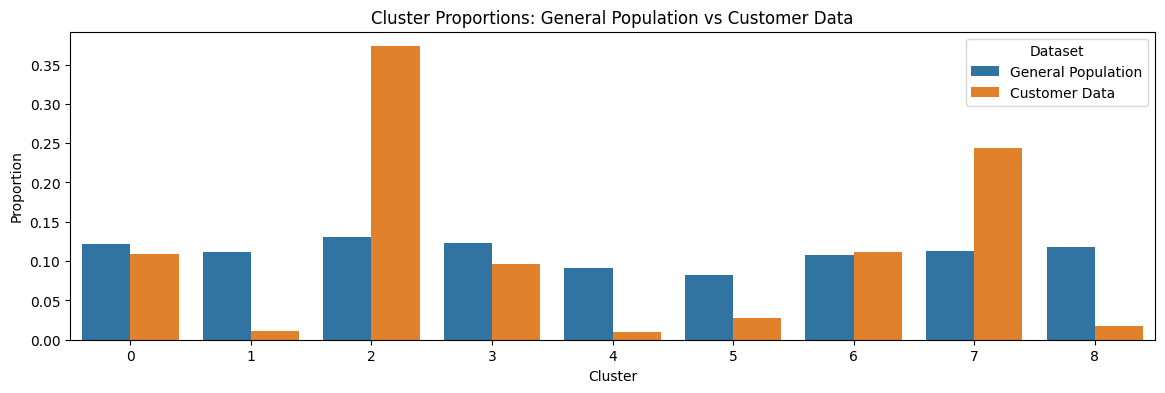

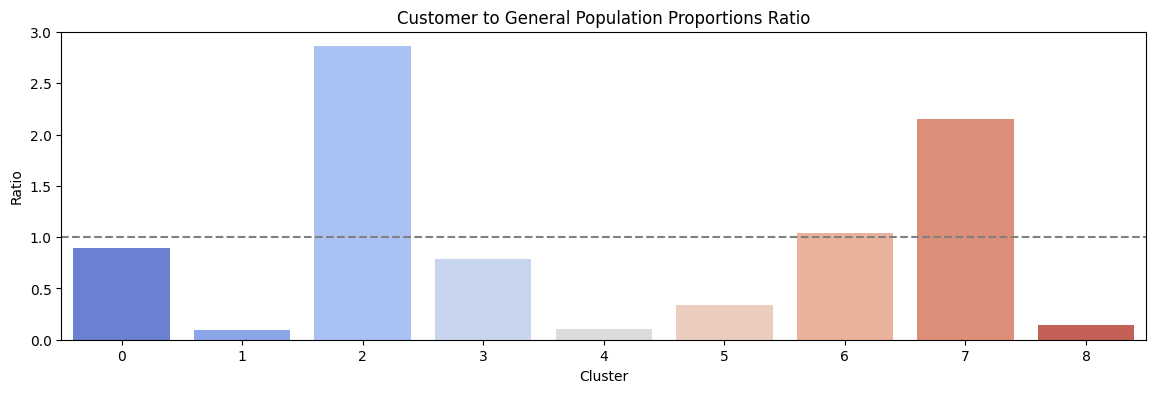

Cluster Centroids in Original Data Space:


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION_DECADE,MOVEMENT_TYPE,WEALTH,LIFE_STAGE
0,3.338073,1.020286,3.409994,3.240891,1.934766,4.248713,1.585467,1.636473,3.654827,5.291719,1961.128838,7.530070,0.091059,2.388837,11.974345,3.730420,2.727420,1.850172,2.143208,1.468027,1.146838,4.462548,4.897249,5.147396,3.833025,4.229997,5.911812,5.061220,4.213259,5.122263,2.671462,3.856515,3.446312,2.871005,3.232221,2.951233,1.492018,0.007506,1.652983,3.838533,13.778336,1.373359,0.006219,5.381923,4.933485,8.138919,15.308411,0.081996,3.404702,2.182472,1992.453322,0.271645,3.506224,0.407084,1.322742,1.156541,0.614549,2.146495,3.291749,4.982618,3.498387,3.393060,2.866761,1.799597,1.751340,4.819239,544.876153,1.541774,3.285169,2.329421,1.203222,2.892835,3.732752,2.781684,3.614048,6.720785,3.706163,0.163544,5.158112,4.295456,2.368837
1,1.779359,1.996977,4.116918,1.221076,4.269713,2.196090,4.114969,3.789062,4.177634,1.955022,1975.479240,8.752303,0.040076,2.203226,10.422914,3.395710,3.031519,1.988535,1.922125,1.151085,1.360864,2.688550,3.184823,3.995384,5.338241,4.680258,2.311015,3.328896,4.549670,4.109376,6.079673,5.499354,6.161547,6.131863,6.079664,5.465729,1.755630,0.007775,1.465911,4.403758,16.748669,1.429505,0.002202,5.600742,4.043317,7.278097,15.046061,0.060335,3.514961,2.087848,1992.416994,0.257900,3.453877,0.391851,1.295694,1.152077,0.619254,2.166447,3.150946,5.130377,3.298497,3.379001,2.890533,1.776947,2.890764,4.918341,527.431184,1.480312,3.308748,2.381863,1.260095,3.069245,3.759335,2.729917,3.644135,6.908216,3.736455,0.910535,3.384880,4.338284,2.059646
2,3.312076,1.506446,3.462136,4.459819,1.826433,4.057265,2.341091,2.123650,1.965323,4.596861,1962.530139,6.432868,0.491582,2.137099,35.587933,10.798257,9.638082,4.843272,8.591496,4.115679,1.058865,3.457547,3.849225,3.414497,3.036465,3.010291,4.609031,4.997827,5.275680,3.581540,3.247598,4.174829,4.592295,4.163533,3.253769,2.924848,1.718935,0.009983,1.489741,2.462605,16.807917,3.245454,0.008167,3.004504,2.862065,8.717569,1.723025,0.009820,2.069480,3.757024,1993.558079,0.144586,4.410634,2.601261,1.070961,0.100794,0.026560,4.119938,4.803903,3.054214,5.334611,4.048964,2.622541,4.164656,3.680977,4.178445,678.411539,2.864150,2.379824,0.956863,0.264944,1.160781,3.463466,3.842825,2.776104,4.171593,2.580573,0.305821,5.117067,2.207115,3.377616
3,3.531718,1.986739,2.899886,2.470045,1.857534,4.345908,2.196286,1.631177,4.384450,4.370180,1959.627576,7.414886,0.068644,1.991506,11.918943,3.676138,2.695276,1.840304,1.913769,1.321578,1.075228,4.282749,3.294720,2.128253,2.045205,2.527665,2.618696,5.309405,6.493694,1.808066,3.378329,5.834382,5.847081,6.186040,2.994252,2.364431,2.096350,0.007677,1.626209,3.333989,13.349077,1.358845,0.003585,5.458068,4.793585,8.134087,15.844632,0.104680,3.333714,2.252102,1992.555854,0.284960,3.449624,0.399949,1.285160,1.149318,0.646340,2.115051,3.390626,5.035461,3.627081,3.443368,2.800213,1.776930,1.656946,4.869944,544.808689,1.588725,3.270682,2.302757,1.182882,2.818218,3.741836,2.822110,3.613594,6.673285,3.649502,0.146856,4.816710,4.274043,2.683555
4

Overrepresented Clusters:


,Cluster,General Population,Customer Data,Ratio
2,2,0.130471,0.373067,2.859384
6,6,0.107618,0.111688,1.037826
7,7,0.113406,0.243660,2.148560



Underrepresented Clusters:


,Cluster,General Population,Customer Data,Ratio
0,0,0.121489,0.109024,0.897398
1,1,0.111823,0.010794,0.096527
3,3,0.123476,0.096904,0.784801
4,4,0.091462,0.009710,0.106159
5,5,0.082262,0.027959,0.339880
8,8,0.117993,0.017194,0.145718


In [59]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# General population cluster proportions
gen_population_cluster_counts = pd.Series(cluster_assignments).value_counts(normalize=True).sort_index()

# Customer data cluster proportions
customer_cluster_counts = pd.Series(customer_clusters).value_counts(normalize=True).sort_index()

# Combine into a DataFrame for comparison
proportions_df = pd.DataFrame({
    "General Population": gen_population_cluster_counts,
    "Customer Data": customer_cluster_counts
}).reset_index().rename(columns={"index": "Cluster"})

# Visualize Proportions using barplot
plt.figure(figsize=(14,4))
sns.barplot(data=proportions_df.melt(id_vars="Cluster", var_name="Dataset", value_name="Proportion"), 
            x="Cluster", y="Proportion", hue="Dataset")
plt.title("Cluster Proportions: General Population vs Customer Data")
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.show()

proportions_df["Ratio"] = proportions_df["Customer Data"] / proportions_df["General Population"]

# Ratio Plot also using barplot
plt.figure(figsize=(14,4))
sns.barplot(data=proportions_df, x="Cluster", y="Ratio", palette="coolwarm")
plt.axhline(1, color="gray", linestyle="--")
plt.title("Customer to General Population Proportions Ratio")
plt.xlabel("Cluster")
plt.ylabel("Ratio")
plt.show()


# Extra Interpret Clusters ..
# Use PCA inverse transform and cluster centroids to interpret
cluster_centroids = final_kmeans.cluster_centers_
original_space_centroids = scaler.inverse_transform(pca.inverse_transform(cluster_centroids))

# Create a DataFrame for easier analysis
centroids_df = pd.DataFrame(original_space_centroids, columns=numeric_columns)
print_styled("Cluster Centroids in Original Data Space:")
display(centroids_df)


# Investigate Overrepresented and Underrepresented Clusters
overrepresented_clusters = proportions_df[proportions_df["Ratio"] > 1]
underrepresented_clusters = proportions_df[proportions_df["Ratio"] < 1]

# Output ..
print_styled("Overrepresented Clusters:")
display(overrepresented_clusters)
print()
print_styled("Underrepresented Clusters:")
display(underrepresented_clusters)

In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Retrieve the cluster center for Cluster 2
cluster_2_center = final_kmeans.cluster_centers_[2]

# Inverse transform using PCA to return to the original scaled feature space
pca_cluster_2 = pca.inverse_transform(cluster_2_center)

# Reshape to 2D before applying scaler.inverse_transform
pca_cluster_2 = pca_cluster_2.reshape(1, -1)

# Inverse transform using the scaler to return to the original feature scale
original_cluster_2 = scaler.inverse_transform(pca_cluster_2)

# Map the result to the original feature column names
cluster_2_features = pd.Series(data=original_cluster_2.flatten(), index= feature_names)

# Display the top features contributing to Cluster 2
print_styled("Cluster 2 (Most Overrepresented) Feature Contributions:")
display(cluster_2_features.sort_values(ascending=False).head(50))


Cluster 2 (Most Overrepresented) Feature Contributions:


MIN_GEBAEUDEJAHR        1993.558079
GEBURTSJAHR             1962.530139
KBA13_ANZAHL_PKW         678.411539
LP_LEBENSPHASE_FEIN       35.587933
ALTER_HH                  16.807917
LP_LEBENSPHASE_GROB       10.798257
LP_FAMILIE_FEIN            9.638082
WOHNDAUER_2008             8.717569
LP_STATUS_FEIN             8.591496
GFK_URLAUBERTYP            6.432868
INNENSTADT                 5.334611
SEMIO_ERL                  5.275680
MOVEMENT_TYPE              5.117067
SEMIO_LUST                 4.997827
LP_FAMILIE_GROB            4.843272
BALLRAUM                   4.803903
SEMIO_VERT                 4.609031
FINANZTYP                  4.596861
SEMIO_DOM                  4.592295
FINANZ_MINIMALIST          4.459819
WOHNLAGE                   4.410634
REGIOTYP                   4.178445
SEMIO_KRIT                 4.174829
ORTSGR_KLS9                4.171593
MOBI_REGIO                 4.164656
SEMIO_KAEM                 4.163533
KBA05_GBZ                  4.119938
LP_STATUS_GROB             4

In [73]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Retrieve the cluster center for Cluster 8
cluster_8_center = final_kmeans.cluster_centers_[8]

# Inverse transform using PCA to return to the original scaled feature space
pca_cluster_8 = pca.inverse_transform(cluster_8_center)

# Reshape to 2D before applying scaler.inverse_transform
pca_cluster_8 = pca_cluster_8.reshape(1, -1)

# Inverse transform using the scaler to return to the original feature scale
original_cluster_8 = scaler.inverse_transform(pca_cluster_8)

# Map the result to the original feature column names
cluster_8_features = pd.Series(data=original_cluster_8.flatten(), index=feature_names)

# Display the top features contributing to Cluster 8
print_styled("Cluster 8 (Most Underrepresented) Feature Contributions:")
display(cluster_8_features.sort_values(ascending=False).head(50))


Cluster 8 (Most Underrepresented) Feature Contributions:


MIN_GEBAEUDEJAHR         1994.150462
GEBURTSJAHR              1977.448715
KBA13_ANZAHL_PKW          708.094964
LP_LEBENSPHASE_FEIN        18.043277
ALTER_HH                   17.200153
GFK_URLAUBERTYP             7.738506
WOHNDAUER_2008              7.560871
SEMIO_DOM                   5.858260
SEMIO_RAT                   5.783345
SEMIO_KRIT                  5.555779
SEMIO_PFLICHT               5.553025
SEMIO_KAEM                  5.516884
LP_LEBENSPHASE_GROB         5.510534
INNENSTADT                  5.485719
SEMIO_TRADV                 5.461837
LP_STATUS_FEIN              5.170892
BALLRAUM                    4.893110
LP_FAMILIE_FEIN             4.890610
SEMIO_REL                   4.877202
SEMIO_MAT                   4.716217
WOHNLAGE                    4.551070
SEMIO_ERL                   4.473613
FINANZ_ANLEGER              4.382537
REGIOTYP                    4.206287
HH_EINKOMMEN_SCORE          4.077632
CJT_GESAMTTYP               4.047238
GEBAEUDETYP_RASTER          3.990634
O

### Discussion 3.3: Compare Customer Data to Demographics Data



##### Overrepresented Clusters (2, 6, 7):
These clusters have higher proportions in the customer dataset compared to the general population, thus these groups are more likely to be the company's target audience. So mail order company should Focus marketing and product strategies on these groups as they are already engaged with the company.

Here's a glimpse using the `pca.inverse_transform`, focusing on Cluster 2 (the most overrepresented).
- **MIN_GEBAEUDEJAHR: 1993.558079**  
  The average year of construction for the buildings is around 1994.

- **GEBURTSJAHR: 1962.530139**  
  The average birth year is around 1963, implying the age group is in their early 60s.

- **KBA13_ANZAHL_PKW: 678.411539**  
  A high number of cars per household

- **LP_LEBENSPHASE_FEIN: 35.587933**  
  likely middle-aged families.

- **ALTER_HH: 16.807917**  
  The average age of the household is about 17 years.


##### Underrepresented Clusters (1, 4, 5, 8)
These clusters have lower proportions in the customer dataset compared to the general population, indicating that the company may not appeal strongly to these groups. **Suggestions** could be: To explore reasons for the lack of engagement in these clusters i.e. (the products irrelevant to them or they may prefer in-store shopping) also mail order company might put more offer to attract these groups if they align with long-term goals if not we can just neglect/de-prioritize marketing efforts to save resources

Here’s a glimpse using the `pca.inverse_transform`, focusing on Cluster 8 (the most underrepresented):

- **MIN_GEBAEUDEJAHR: 1994.150462**  
  The average year of construction for buildings

- **GEBURTSJAHR: 1977.448715**  
  The average birth year is 1977, indicating a younger demographic (mid-40s age group).

- **KBA13_ANZAHL_PKW: 708.094964**  
  A higher number of cars per household, suggesting greater mobility and an urban/suburban lifestyle.

- **LP_LEBENSPHASE_FEIN: 18.043277**  
  This corresponds to early stages of life, possibly young professionals or families in the growth phase.

- **ALTER_HH: 17.200153**  
  Households in this cluster are relatively new or younger, implying a transient or less established lifestyle.

- **GFK_URLAUBERTYP: 7.738506**  
  Higher contribution from vacation preferences, suggesting travel and leisure activities play an important role for this group.

- **SEMIO_DOM: 5.858260**  
  Dominance and assertiveness are notable psychographic traits for this cluster, which might indicate a preference for decision-making and control.

- **SEMIO_RAT: 5.783345**  
  Rationality and practicality are important traits in this group, suggesting they value functionality over luxury.

- **WOHNDAUER_2008: 7.560871**  
  Relatively shorter residential duration, possibly more mobile population.
  
##### Take away:
While there are shared features between Cluster 2 (the most overrepresented) and Cluster 8 (the most underrepresented), their overall profiles and driving characteristics are fundamentally different. Cluster 2 is more about stability, affluence, and established households, while Cluster 8 leans toward youth, mobility, and diverse psychographic traits.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.